Imports

In [1]:
import jax
import jax.numpy as jnp

import blackjax

import numpy as np

import matplotlib.pyplot as plt

Set seed

In [2]:
key = jax. random.PRNGKey(548)

Definine MH-Adjusted Microcanonical Markov Chain Monte Carlo

See: https://blackjax-devs.github.io/sampling-book/algorithms/mclmc.html#adjusted-mclmc

In [5]:
from blackjax.mcmc.adjusted_mclmc_dynamic import rescale
from blackjax.util import run_inference_algorithm

def run_adjusted_mclmc_dynamic(
    logdensity_fn,
    num_steps,
    initial_position,
    key,
    transform=lambda state, _ : state.position,
    diagonal_preconditioning=True,
    random_trajectory_length=True,
    L_proposal_factor=jnp.inf
):

    init_key, tune_key, run_key = jax.random.split(key, 3)

    initial_state = blackjax.mcmc.adjusted_mclmc_dynamic.init(
        position=initial_position,
        logdensity_fn=logdensity_fn,
        random_generator_arg=init_key,
    )

    if random_trajectory_length:
        integration_steps_fn = lambda avg_num_integration_steps: lambda k: jnp.ceil(
            jax.random.uniform(k) * rescale(avg_num_integration_steps))
    else:
        integration_steps_fn = lambda avg_num_integration_steps: lambda _: jnp.ceil(avg_num_integration_steps)

    kernel = lambda rng_key, state, avg_num_integration_steps, step_size, inverse_mass_matrix: blackjax.mcmc.adjusted_mclmc_dynamic.build_kernel(
        integration_steps_fn=integration_steps_fn(avg_num_integration_steps),
        inverse_mass_matrix=inverse_mass_matrix,
    )(
        rng_key=rng_key,
        state=state,
        step_size=step_size,
        logdensity_fn=logdensity_fn,
        L_proposal_factor=L_proposal_factor,
    )

    target_acc_rate = 0.9 # our recommendation

    (
        blackjax_state_after_tuning,
        blackjax_mclmc_sampler_params,
        _
    ) = blackjax.adjusted_mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_steps,
        state=initial_state,
        rng_key=tune_key,
        target=target_acc_rate,
        frac_tune1=0.1,
        frac_tune2=0.1,
        frac_tune3=0.1, # our recommendation
        diagonal_preconditioning=diagonal_preconditioning,
    )

    step_size = blackjax_mclmc_sampler_params.step_size
    L = blackjax_mclmc_sampler_params.L

    alg = blackjax.adjusted_mclmc_dynamic(
        logdensity_fn=logdensity_fn,
        step_size=step_size,
        integration_steps_fn=lambda key: jnp.ceil(
            jax.random.uniform(key) * rescale(L / step_size)
        ),
        inverse_mass_matrix=blackjax_mclmc_sampler_params.inverse_mass_matrix,
        L_proposal_factor=L_proposal_factor,
    )

    _, out = run_inference_algorithm(
        rng_key=run_key,
        initial_state=blackjax_state_after_tuning,
        inference_algorithm=alg,
        num_steps=num_steps,
        transform=transform,
        progress_bar=False,
    )

    return out

Text(0.5, 1.0, 'Scatter Plot of Samples')

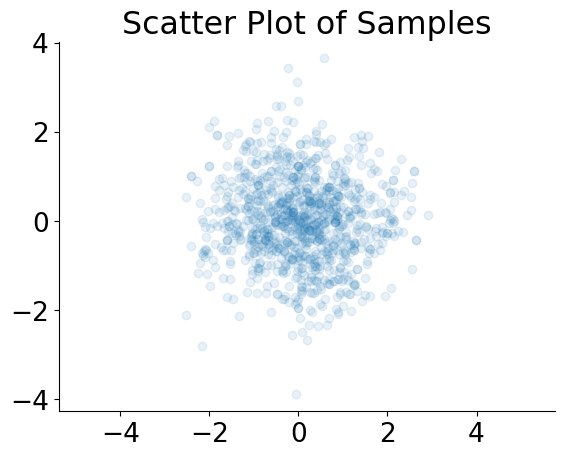

In [8]:
import matplotlib.pyplot as plt

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 19

import jax
import blackjax
import numpy as np
import jax.numpy as jnp
from datetime import date
import numpyro
import numpyro.distributions as dist

from numpyro.infer.util import initialize_model

rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))

# run the algorithm on a high dimensional gaussian, and show two of the dimensions

sample_key, rng_key = jax.random.split(rng_key)
samples = run_adjusted_mclmc_dynamic(
    logdensity_fn=lambda x: -0.5 * jnp.sum(jnp.square(x)),
    num_steps=1000,
    initial_position=jnp.ones((1000,)),
    key=sample_key,
)
plt.scatter(x=samples[:, 0], y=samples[:, 1], alpha=0.1)
plt.axis("equal")
plt.title("Scatter Plot of Samples")

Use NUTS

See: https://github.com/blackjax-devs/blackjax

In [9]:
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import numpy as np

import blackjax

observed = np.random.normal(10, 20, size=1_000)
def logdensity_fn(x):
    logpdf = stats.norm.logpdf(observed, x["loc"], x["scale"])
    return jnp.sum(logpdf)

# Build the kernel
step_size = 1e-3
inverse_mass_matrix = jnp.array([1., 1.])
nuts = blackjax.nuts(logdensity_fn, step_size, inverse_mass_matrix)

# Initialize the state
initial_position = {"loc": 1., "scale": 2.}
state = nuts.init(initial_position)

# Iterate
rng_key = jax.random.key(0)
step = jax.jit(nuts.step)
for i in range(100):
    nuts_key = jax.random.fold_in(rng_key, i)
    state, _ = step(nuts_key, state)

BAYESIAN OPTIMIZATION OF MCMC HYPERPARAMETERS
Target Distribution: Neal's Funnel (dimension=10)
Objective: λ * ESS - (acceptance - target)²

📊 Configuration:
   NUTS  Target Acceptance: 0.75
   MCLMC Target Acceptance: 0.75
   MAMS  Target Acceptance: 0.90
   Lambda (λ) for ESS:      0.05

OPTIMIZING NUTS HYPERPARAMETERS

Phase 1: Initial Random Sampling (5 evaluations)
Objective: λ * ESS - (acceptance - 0.75)²
Lambda (λ): 0.05
  [1/5] step_size=0.1935 max_num_doublings=11.6550 
      → Obj=7.24, ESS/s=145.78, Accept=0.961, Error²=0.0447
  [2/5] step_size=0.3687 max_num_doublings=9.1906 
      → Obj=10.04, ESS/s=201.03, Accept=0.835, Error²=0.0072
  [3/5] step_size=0.0864 max_num_doublings=6.0920 
      → Obj=1.45, ESS/s=30.07, Accept=0.977, Error²=0.0514
  [4/5] step_size=0.0385 max_num_doublings=11.0632 
      → Obj=1.82, ESS/s=37.57, Accept=0.997, Error²=0.0612
  [5/5] step_size=0.3045 max_num_doublings=9.9565 
      → Obj=18.06, ESS/s=362.02, Accept=0.953, Error²=0.0411

Phase 2: B

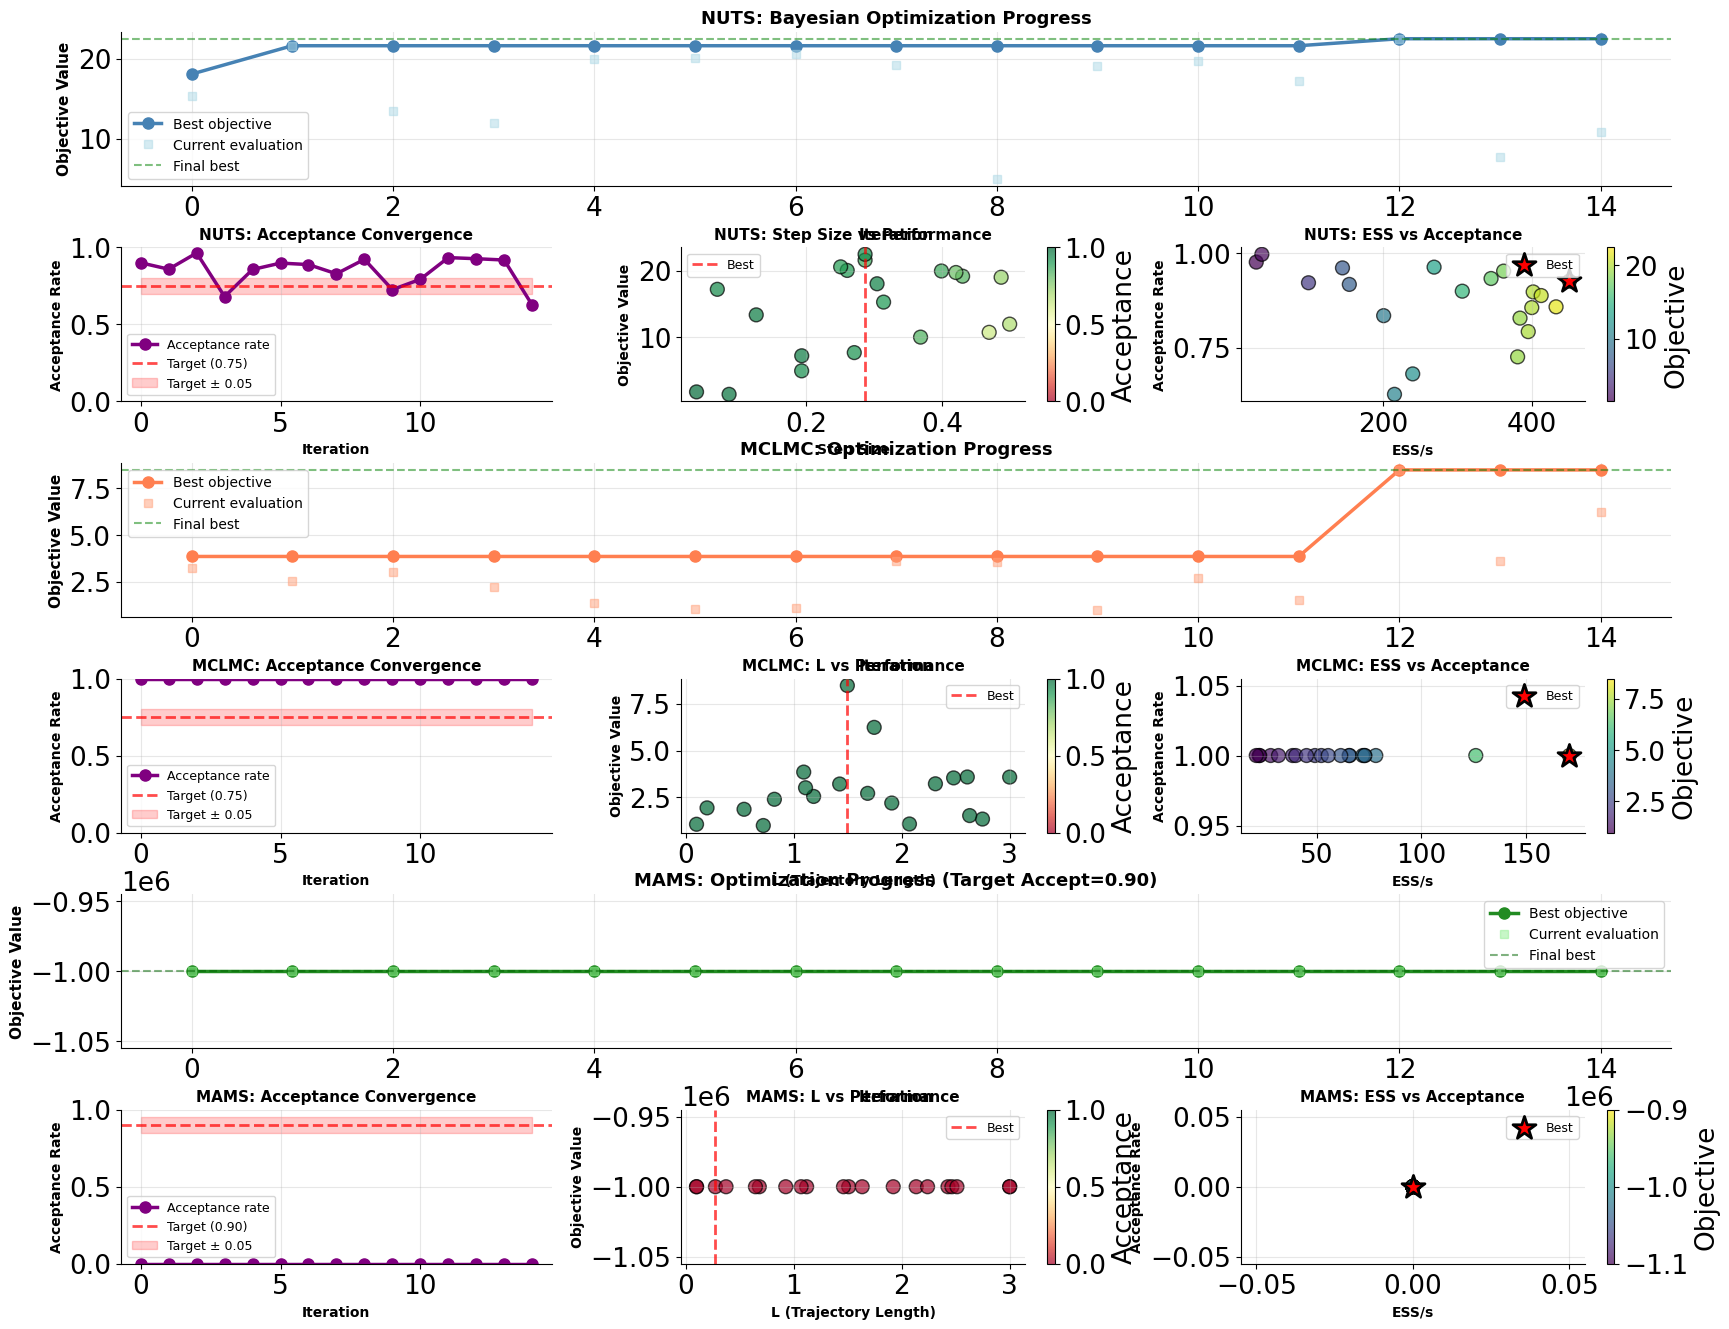


FINAL COMPARISON: NUTS vs MCLMC vs MAMS
Method          Objective    ESS/s        Accept       Target       Error²      
--------------------------------------------------------------------------------
NUTS            22.48        450.27       0.926        0.75         0.0310      
MCLMC           8.48         170.87       1.000        0.75         0.0625      
MAMS            -1000000.00  0.00         0.000        0.90         0.8100      
--------------------------------------------------------------------------------
🏆 Winner: NUTS (objective 22.48)

ESS/s COMPARISON (Raw Performance)
Fastest sampling: NUTS (450.27 ESS/s)

Speedups relative to NUTS:
  MCLMC: 0.38x
  MAMS:  0.00x

OPTIMIZATION SUMMARY

📊 NUTS Best Configuration:
----------------------------------------
  • step_size................ 0.2869
  • max_num_doublings........ 10.2149
  • Objective Value.......... 22.48
  • ESS per Second........... 450.27
  • Acceptance Rate.......... 0.926
  • Target Acceptance........ 0.7

In [11]:
"""
Bayesian Optimization for MCMC Hyperparameter Tuning with MAMS

This script demonstrates how to use Bayesian optimization to tune hyperparameters
for three state-of-the-art MCMC samplers: NUTS, MCLMC, and MAMS.

MAMS (Metropolis-Adjusted Microcanonical Sampler):
- Combines microcanonical dynamics with Metropolis-Hastings correction
- Produces unbiased samples (unlike MCLMC)
- Shows 2-7x speedup over NUTS on benchmark problems
- Target acceptance rate: ~90% (higher than HMC's optimal 65%)

Key Features:
- Custom Gaussian Process implementation for surrogate modeling
- Expected Improvement acquisition function for intelligent exploration
- Multi-objective optimization: maximize ESS while targeting acceptance rate
- Comprehensive visualization of optimization progress

Author: Bayesian Optimization Demo
Target Distribution: Neal's Funnel (challenging geometry for MCMC)
"""

import jax
import jax.numpy as jnp
import blackjax
import numpy as np
from scipy import stats
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Callable, Optional
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
key = jax.random.PRNGKey(42)

# ============================================================================
# Target Distribution: Neal's Funnel
# ============================================================================

def logdensity_fn(x):
    """
    Neal's funnel distribution - a challenging test case for MCMC samplers.
    
    This distribution has a hierarchical structure where the scale of dimensions
    1 through N depends on dimension 0, creating a "funnel" shape that challenges
    samplers due to varying curvature.
    
    Structure:
        x[0] ~ N(0, 3)
        x[i] ~ N(0, exp(x[0]/2)) for i > 0
    
    Args:
        x: Position vector in R^d
        
    Returns:
        Log probability density at position x
        
    Note:
        This distribution is difficult because:
        1. Narrow "neck" when x[0] is negative (small variance)
        2. Wide "mouth" when x[0] is positive (large variance)
        3. Requires adaptive step sizes across the distribution
    """
    dim = len(x)
    log_prob = -0.5 * (x[0]**2 / 9.0)  # Prior on x[0]
    log_prob += -0.5 * (dim - 1) * x[0]  # Jacobian adjustment
    log_prob += -0.5 * jnp.sum(x[1:]**2 * jnp.exp(-x[0]))  # Conditional on x[0]
    return log_prob


# Problem setup
dim = 10
initial_position = jnp.zeros(dim)

# ============================================================================
# Bayesian Optimization Components
# ============================================================================

class GaussianProcess:
    """
    Gaussian Process for Bayesian Optimization.
    
    A GP provides a probabilistic model of the objective function, allowing us
    to model uncertainty and make informed decisions about where to sample next.
    
    Attributes:
        lengthscale: Controls how quickly the correlation between points decays
        signal_variance: Controls the overall scale of function variations
        noise_variance: Models observation noise in function evaluations
    """
    
    def __init__(self, lengthscale=1.0, signal_variance=1.0, noise_variance=1e-6):
        """
        Initialize Gaussian Process.
        
        Args:
            lengthscale: RBF kernel lengthscale parameter
            signal_variance: Prior variance on function values
            noise_variance: Observation noise level
        """
        self.lengthscale = lengthscale
        self.signal_variance = signal_variance
        self.noise_variance = noise_variance
        self.X_train = None
        self.y_train = None
        self.K_inv = None
        
    def rbf_kernel(self, X1, X2):
        """
        Radial Basis Function (RBF) kernel, also known as squared exponential.
        
        K(x, x') = σ² * exp(-||x - x'||² / (2ℓ²))
        
        Args:
            X1: First set of points (n1 × d)
            X2: Second set of points (n2 × d)
            
        Returns:
            Kernel matrix (n1 × n2)
        """
        sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
        return self.signal_variance * np.exp(-0.5 / self.lengthscale**2 * sqdist)
    
    def fit(self, X, y):
        """
        Fit GP to observed data.
        
        Computes and stores the inverse covariance matrix for efficient prediction.
        
        Args:
            X: Training inputs (n × d)
            y: Training outputs (n,)
        """
        self.X_train = X
        self.y_train = y
        K = self.rbf_kernel(X, X) + self.noise_variance * np.eye(len(X))
        self.K_inv = np.linalg.inv(K)
        
    def predict(self, X_test):
        """
        Predict mean and standard deviation at test points.
        
        Uses the GP posterior distribution:
            μ(x*) = k(x*)ᵀ K⁻¹ y
            σ²(x*) = k(x*, x*) - k(x*)ᵀ K⁻¹ k(x*)
        
        Args:
            X_test: Test inputs (m × d)
            
        Returns:
            mu: Posterior mean (m,)
            std: Posterior standard deviation (m,)
        """
        if self.X_train is None:
            return np.zeros(len(X_test)), np.ones(len(X_test))
        
        K_s = self.rbf_kernel(self.X_train, X_test)
        K_ss = self.rbf_kernel(X_test, X_test)
        
        # Posterior mean
        mu = K_s.T @ self.K_inv @ self.y_train
        
        # Posterior variance
        var = np.diag(K_ss) - np.diag(K_s.T @ self.K_inv @ K_s)
        var = np.maximum(var, 1e-8)  # Numerical stability
        
        return mu, np.sqrt(var)


def expected_improvement(X, X_sample, Y_sample, gp, xi=0.01):
    """
    Expected Improvement (EI) acquisition function.
    
    EI balances exploration (high uncertainty) and exploitation (high predicted value).
    It measures the expected improvement over the current best observation.
    
    EI(x) = E[max(f(x) - f(x⁺), 0)]
          = (μ(x) - f(x⁺) - ξ) * Φ(Z) + σ(x) * φ(Z)
    
    where Z = (μ(x) - f(x⁺) - ξ) / σ(x)
    
    Args:
        X: Candidate points to evaluate (m × d)
        X_sample: Previously sampled points (n × d)
        Y_sample: Observed function values (n,)
        gp: Fitted Gaussian Process model
        xi: Exploration-exploitation trade-off parameter (default: 0.01)
            Higher values encourage more exploration
            
    Returns:
        Expected improvement at each candidate point (m,)
    """
    mu, sigma = gp.predict(X)
    mu_sample = gp.predict(X_sample)[0]
    
    mu = mu.reshape(-1, 1)
    sigma = sigma.reshape(-1, 1)
    
    # Current best observation
    mu_sample_opt = np.max(mu_sample)
    
    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * stats.norm.cdf(Z) + sigma * stats.norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    
    return ei


def propose_location(acquisition, X_sample, Y_sample, gp, bounds, n_restarts=25):
    """
    Propose next sampling location by optimizing the acquisition function.
    
    Uses multi-start L-BFGS-B optimization to find the point that maximizes
    the acquisition function (e.g., Expected Improvement).
    
    Args:
        acquisition: Acquisition function to optimize
        X_sample: Previously sampled points
        Y_sample: Observed function values
        gp: Fitted Gaussian Process
        bounds: Parameter bounds (d × 2)
        n_restarts: Number of random initializations for optimization
        
    Returns:
        Proposed next point to sample (1 × d)
    """
    dim = bounds.shape[0]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimize negative acquisition (i.e., maximize acquisition)
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gp)
    
    # Multi-start optimization to avoid local minima
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x
    
    return min_x.reshape(-1, dim)


# ============================================================================
# MCMC Performance Metrics
# ============================================================================

def compute_ess_simple(samples):
    """
    Compute Effective Sample Size (ESS) using autocorrelation.
    
    ESS measures the number of independent samples that would provide the same
    statistical efficiency as the correlated MCMC samples.
    
    Formula:
        ESS = N / (1 + 2 * Σ ρ(k))
        
    where ρ(k) is the autocorrelation at lag k.
    
    Args:
        samples: MCMC samples (n_samples × n_dims)
        
    Returns:
        Average ESS across dimensions
        
    Note:
        Only computes ESS for first 3 dimensions for computational efficiency
    """
    n_samples, n_dims = samples.shape
    ess_values = []
    
    for d in range(min(n_dims, 3)):  # First 3 dims for speed
        x = samples[:, d]
        x = x - np.mean(x)
        
        # Compute autocorrelation function
        autocorr = np.correlate(x, x, mode='full')
        autocorr = autocorr[len(autocorr)//2:]
        autocorr = autocorr / autocorr[0]
        
        # Sum positive autocorrelations (integrated autocorrelation time)
        max_lag = min(len(autocorr) // 2, 100)
        tau = 1 + 2 * np.sum(autocorr[1:max_lag][autocorr[1:max_lag] > 0])
        ess_values.append(n_samples / max(tau, 1.0))
    
    return np.mean(ess_values)


def compute_acceptance_rate(samples, threshold=1e-8):
    """
    Estimate acceptance rate by detecting duplicate samples.
    
    When a proposal is rejected, MCMC keeps the current state, resulting
    in consecutive duplicate samples.
    
    Args:
        samples: MCMC samples (n_samples × n_dims)
        threshold: Tolerance for considering samples as duplicates
        
    Returns:
        Estimated acceptance rate
    """
    n_samples = len(samples)
    if n_samples < 2:
        return 1.0
    
    # Count transitions (non-duplicate consecutive samples)
    diffs = np.abs(np.diff(samples, axis=0))
    transitions = np.sum(np.any(diffs > threshold, axis=1))
    
    return transitions / (n_samples - 1)


# ============================================================================
# Multi-Objective Functions for Samplers
# ============================================================================

def evaluate_nuts(params: Dict, logdensity: Callable, initial_pos: jnp.ndarray,
                  target_acceptance: float = 0.8, lambda_ess: float = 1.0,
                  n_samples: int = 1000) -> Tuple[float, float, float]:
    """
    Evaluate NUTS sampler with given hyperparameters.
    
    Returns ESS, acceptance rate, and combined objective for multi-objective optimization.
    
    Args:
        params: Dictionary containing:
            - step_size: Integration step size for leapfrog integrator
            - max_num_doublings: Maximum tree depth (controls trajectory length)
        logdensity: Log density function of target distribution
        initial_pos: Starting position for sampler
        target_acceptance: Desired acceptance rate (default: 0.8)
        lambda_ess: Weight for ESS term in objective (default: 1.0)
        n_samples: Number of samples to draw
        
    Returns:
        Tuple of (objective_value, acceptance_rate, ess) where:
            - objective_value: λ * ESS - (acceptance - target)²
            - acceptance_rate: Actual acceptance rate achieved
            - ess: Effective sample size per second
    """
    global key
    
    step_size = params['step_size']
    max_doublings = int(params['max_num_doublings'])
    
    try:
        key, init_key = jax.random.split(key)
        
        # Create inverse mass matrix (identity = no preconditioning)
        inverse_mass_matrix = jnp.ones(len(initial_pos))
        
        # Build NUTS sampler
        nuts = blackjax.nuts(
            logdensity,
            step_size=step_size,
            inverse_mass_matrix=inverse_mass_matrix,
            max_num_doublings=max_doublings
        )
        
        # Initialize state
        state = nuts.init(initial_pos)
        kernel = nuts.step
        
        # Run MCMC sampling
        key, sample_key = jax.random.split(key)
        keys = jax.random.split(sample_key, n_samples)
        
        def one_step(state, rng_key):
            state, info = kernel(rng_key, state)
            return state, (state.position, info.acceptance_rate)
        
        start_time = time.time()
        _, (samples, accept_rates) = jax.lax.scan(one_step, state, keys)
        elapsed = time.time() - start_time
        
        samples_np = np.array(samples)
        accept_rates_np = np.array(accept_rates)
        
        # Check for numerical issues
        if np.any(np.isnan(samples_np)) or np.any(np.isinf(samples_np)):
            return -1e6, 0.0, 0.0
        
        # Compute metrics
        ess = compute_ess_simple(samples_np)
        ess_per_sec = ess / max(elapsed, 0.01)
        
        # Average acceptance rate
        avg_acceptance = float(np.mean(accept_rates_np))
        
        # Multi-objective: λ * ESS - squared distance from target acceptance
        acceptance_error = (avg_acceptance - target_acceptance) ** 2
        objective = lambda_ess * ess_per_sec - acceptance_error
        
        return objective, avg_acceptance, ess_per_sec
        
    except Exception as e:
        print(f"NUTS evaluation failed: {e}")
        return -1e6, 0.0, 0.0


def evaluate_mclmc(params: Dict, logdensity: Callable, initial_pos: jnp.ndarray,
                   target_acceptance: float = 0.8, lambda_ess: float = 1.0,
                   n_samples: int = 1000) -> Tuple[float, float, float]:
    """
    Evaluate MCLMC (Microcanonical Langevin Monte Carlo) sampler.
    
    MCLMC uses continuous dynamics with irreversible moves for efficient sampling.
    
    Args:
        params: Dictionary containing:
            - L: Trajectory length (time horizon for dynamics)
            - step_size: Integration step size
        logdensity: Log density function of target distribution
        initial_pos: Starting position
        target_acceptance: Desired acceptance rate (for consistency, though MCLMC
                          doesn't have explicit accept/reject steps like MH)
        lambda_ess: Weight for ESS term in objective (default: 1.0)
        n_samples: Number of samples to draw
        
    Returns:
        Tuple of (objective_value, acceptance_rate_estimate, ess)
    """
    global key
    
    L = params['L']
    step_size = params['step_size']
    
    try:
        key, init_key = jax.random.split(key)
        
        # Initialize MCLMC state
        state = blackjax.mcmc.mclmc.init(
            position=initial_pos,
            logdensity_fn=logdensity,
            rng_key=init_key
        )
        
        # Build sampler
        sampling_alg = blackjax.mclmc(
            logdensity,
            L=L,
            step_size=step_size
        )
        mclmc_kernel = sampling_alg.step
        
        # Run sampling
        key, sample_key = jax.random.split(key)
        keys = jax.random.split(sample_key, n_samples)
        
        def one_step(state, rng_key):
            state, info = mclmc_kernel(rng_key, state)
            return state, state.position
        
        start_time = time.time()
        _, samples = jax.lax.scan(one_step, state, keys)
        elapsed = time.time() - start_time
        
        samples_np = np.array(samples)
        
        # Check validity
        if np.any(np.isnan(samples_np)) or np.any(np.isinf(samples_np)):
            return -1e6, 0.0, 0.0
        
        # Compute metrics
        ess = compute_ess_simple(samples_np)
        ess_per_sec = ess / max(elapsed, 0.01)
        
        # Estimate acceptance rate from sample diversity
        acceptance_est = compute_acceptance_rate(samples_np)
        
        # Multi-objective: λ * ESS - squared distance from target acceptance
        acceptance_error = (acceptance_est - target_acceptance) ** 2
        objective = lambda_ess * ess_per_sec - acceptance_error
        
        return objective, acceptance_est, ess_per_sec
        
    except Exception as e:
        print(f"MCLMC evaluation failed: {e}")
        return -1e6, 0.0, 0.0


def evaluate_mams(params: Dict, logdensity: Callable, initial_pos: jnp.ndarray,
                  target_acceptance: float = 0.9, lambda_ess: float = 1.0,
                  n_samples: int = 1000) -> Tuple[float, float, float]:
    """
    Evaluate MAMS (Metropolis-Adjusted Microcanonical Sampler).
    
    MAMS combines microcanonical dynamics with Metropolis-Hastings correction
    for unbiased sampling. Optimal acceptance rate is ~90% (higher than HMC).
    
    Args:
        params: Dictionary containing:
            - L: Trajectory length (microcanonical integration time)
            - step_size: Integration step size
        logdensity: Log density function of target distribution
        initial_pos: Starting position
        target_acceptance: Desired acceptance rate (default: 0.9)
        lambda_ess: Weight for ESS term in objective (default: 1.0)
        n_samples: Number of samples to draw
        
    Returns:
        Tuple of (objective_value, acceptance_rate, ess)
        
    Note:
        MAMS paper (Robnik et al. 2025) shows 2-7x speedup over NUTS.
        Target acceptance: ~90% (vs ~65% for standard HMC)
    """
    global key
    
    L = params['L']
    step_size = params['step_size']
    
    try:
        key, init_key = jax.random.split(key)
        
        # Initialize MAMS state
        state = blackjax.mcmc.mams.init(
            position=initial_pos,
            logdensity_fn=logdensity,
            rng_key=init_key
        )
        
        # Build MAMS sampler
        sampling_alg = blackjax.mams(
            logdensity,
            L=L,
            step_size=step_size
        )
        mams_kernel = sampling_alg.step
        
        # Run sampling
        key, sample_key = jax.random.split(key)
        keys = jax.random.split(sample_key, n_samples)
        
        def one_step(state, rng_key):
            state, info = mams_kernel(rng_key, state)
            # MAMS returns acceptance probability in info
            acceptance = info.acceptance_rate if hasattr(info, 'acceptance_rate') else info.is_accepted
            return state, (state.position, acceptance)
        
        start_time = time.time()
        _, (samples, accept_info) = jax.lax.scan(one_step, state, keys)
        elapsed = time.time() - start_time
        
        samples_np = np.array(samples)
        
        # Check validity
        if np.any(np.isnan(samples_np)) or np.any(np.isinf(samples_np)):
            return -1e6, 0.0, 0.0
        
        # Compute metrics
        ess = compute_ess_simple(samples_np)
        ess_per_sec = ess / max(elapsed, 0.01)
        
        # Get acceptance rate
        accept_info_np = np.array(accept_info)
        if accept_info_np.ndim > 1:
            avg_acceptance = float(np.mean(accept_info_np))
        else:
            # Fallback: estimate from sample diversity
            avg_acceptance = compute_acceptance_rate(samples_np)
        
        # Multi-objective: λ * ESS - squared distance from target acceptance
        acceptance_error = (avg_acceptance - target_acceptance) ** 2
        objective = lambda_ess * ess_per_sec - acceptance_error
        
        return objective, avg_acceptance, ess_per_sec
        
    except Exception as e:
        print(f"MAMS evaluation failed: {e}")
        return -1e6, 0.0, 0.0


# ============================================================================
# Bayesian Optimization Loop
# ============================================================================

def bayesian_optimization(objective_fn: Callable, bounds: np.ndarray, param_names: list,
                         n_iterations: int = 20, n_initial: int = 5,
                         target_acceptance: float = 0.8, lambda_ess: float = 1.0):
    """
    Run Bayesian optimization to find optimal hyperparameters.
    """
    
    dim = bounds.shape[0]
    
    # ========================================================================
    # Phase 1: Initial Random Sampling
    # ========================================================================
    print(f"\n{'='*80}")
    print(f"Phase 1: Initial Random Sampling ({n_initial} evaluations)")
    print(f"{'='*80}")
    print(f"Objective: λ * ESS - (acceptance - {target_acceptance})²")
    print(f"Lambda (λ): {lambda_ess}")
    
    X_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_initial, dim))
    Y_sample = []
    acceptance_rates = []
    ess_values = []
    
    for i, x in enumerate(X_sample):
        params = {name: val for name, val in zip(param_names, x)}
        y, acc_rate, ess = objective_fn(params)
        Y_sample.append(y)
        acceptance_rates.append(acc_rate)
        ess_values.append(ess)
        
        acc_error = (acc_rate - target_acceptance) ** 2
        print(f"  [{i+1}/{n_initial}] ", end="")
        for name, val in params.items():
            print(f"{name}={val:.4f} ", end="")
        print(f"\n      → Obj={y:.2f}, ESS/s={ess:.2f}, Accept={acc_rate:.3f}, Error²={acc_error:.4f}")
    
    X_sample = np.array(X_sample)
    Y_sample = np.array(Y_sample)
    acceptance_rates = np.array(acceptance_rates)
    ess_values = np.array(ess_values)
    
    # ========================================================================
    # Phase 2: Bayesian Optimization
    # ========================================================================
    print(f"\n{'='*80}")
    print(f"Phase 2: Bayesian Optimization ({n_iterations} iterations)")
    print(f"Target acceptance rate: {target_acceptance:.2f}")
    print(f"Lambda (λ): {lambda_ess}")
    print(f"{'='*80}")
    
    gp = GaussianProcess(lengthscale=0.5, signal_variance=1.0, noise_variance=1e-4)
    
    history = {
        'iteration': [],
        'params': [],
        'values': [],
        'acceptance_rates': [],
        'ess_values': [],
        'best_value': [],
        'best_params': [],
        'best_acceptance': [],
        'best_ess': []
    }
    
    for i in range(n_iterations):
        # Fit GP to current data
        gp.fit(X_sample, Y_sample)
        
        # Propose next point using Expected Improvement
        X_next = propose_location(expected_improvement, X_sample, Y_sample, gp, bounds)
        
        # Evaluate objective
        params = {name: val for name, val in zip(param_names, X_next[0])}
        Y_next, acc_rate, ess = objective_fn(params)
        
        # Update dataset
        X_sample = np.vstack((X_sample, X_next))
        Y_sample = np.append(Y_sample, Y_next)
        acceptance_rates = np.append(acceptance_rates, acc_rate)
        ess_values = np.append(ess_values, ess)
        
        # Track best so far
        best_idx = np.argmax(Y_sample)
        best_value = Y_sample[best_idx]
        best_acceptance = acceptance_rates[best_idx]
        best_ess = ess_values[best_idx]
        best_params = {name: val for name, val in zip(param_names, X_sample[best_idx])}
        
        # Store history
        history['iteration'].append(i)
        history['params'].append(params)
        history['values'].append(Y_next)
        history['acceptance_rates'].append(acc_rate)
        history['ess_values'].append(ess)
        history['best_value'].append(best_value)
        history['best_params'].append(best_params)
        history['best_acceptance'].append(best_acceptance)
        history['best_ess'].append(best_ess)
        
        # Print progress
        acc_error = (acc_rate - target_acceptance) ** 2
        print(f"\n  Iteration {i+1}/{n_iterations}")
        print(f"  Proposed: ", end="")
        for name, val in params.items():
            print(f"{name}={val:.4f} ", end="")
        print(f"\n  Result: Obj={Y_next:.2f}, ESS/s={ess:.2f}, Accept={acc_rate:.3f}, Error²={acc_error:.4f}")
        print(f"  Best so far: Obj={best_value:.2f}, ESS/s={best_ess:.2f}, Accept={best_acceptance:.3f}")
    
    # Final results
    best_idx = np.argmax(Y_sample)
    best_params = {name: val for name, val in zip(param_names, X_sample[best_idx])}
    best_value = Y_sample[best_idx]
    best_acceptance = acceptance_rates[best_idx]
    best_ess = ess_values[best_idx]
    
    return best_params, best_value, best_acceptance, best_ess, history, X_sample, Y_sample, acceptance_rates, ess_values


# ============================================================================
# Main Optimization
# ============================================================================

print("=" * 80)
print("BAYESIAN OPTIMIZATION OF MCMC HYPERPARAMETERS")
print("=" * 80)
print(f"Target Distribution: Neal's Funnel (dimension={dim})")
print(f"Objective: λ * ESS - (acceptance - target)²")
print("=" * 80)

# ============================================================================
# Hyperparameter Configuration
# ============================================================================
TARGET_ACCEPTANCE_NUTS = 0.75   # NUTS target
TARGET_ACCEPTANCE_MCLMC = 0.75  # MCLMC target (estimated)
TARGET_ACCEPTANCE_MAMS = 0.90   # MAMS target (optimal ~90%)
LAMBDA_ESS = 0.05               # Weight for ESS term

print(f"\n📊 Configuration:")
print(f"   NUTS  Target Acceptance: {TARGET_ACCEPTANCE_NUTS:.2f}")
print(f"   MCLMC Target Acceptance: {TARGET_ACCEPTANCE_MCLMC:.2f}")
print(f"   MAMS  Target Acceptance: {TARGET_ACCEPTANCE_MAMS:.2f}")
print(f"   Lambda (λ) for ESS:      {LAMBDA_ESS:.2f}")

# ============================================================================
# 1. Optimize NUTS
# ============================================================================
print("\n" + "=" * 80)
print("OPTIMIZING NUTS HYPERPARAMETERS")
print("=" * 80)

nuts_bounds = np.array([
    [0.01, 0.5],     # step_size
    [5, 12]          # max_num_doublings
])

nuts_param_names = ['step_size', 'max_num_doublings']

nuts_objective = lambda params: evaluate_nuts(
    params, logdensity_fn, initial_position,
    target_acceptance=TARGET_ACCEPTANCE_NUTS, lambda_ess=LAMBDA_ESS, n_samples=1000
)

(nuts_best_params, nuts_best_value, nuts_best_acceptance, nuts_best_ess,
 nuts_history, nuts_X, nuts_Y, nuts_accept, nuts_ess_vals) = bayesian_optimization(
    nuts_objective, nuts_bounds, nuts_param_names,
    n_iterations=15, n_initial=5, target_acceptance=TARGET_ACCEPTANCE_NUTS,
    lambda_ess=LAMBDA_ESS
)

print("\n" + "-" * 80)
print("NUTS OPTIMIZATION RESULTS")
print("-" * 80)
print(f"Best hyperparameters:")
for name, value in nuts_best_params.items():
    print(f"  {name}: {value:.4f}")
print(f"Best objective value: {nuts_best_value:.2f}")
print(f"Best ESS/second: {nuts_best_ess:.2f}")
print(f"Achieved acceptance rate: {nuts_best_acceptance:.3f}")
print(f"Target acceptance rate: {TARGET_ACCEPTANCE_NUTS:.3f}")
print(f"Squared error: {(nuts_best_acceptance - TARGET_ACCEPTANCE_NUTS)**2:.4f}")

# ============================================================================
# 2. Optimize MCLMC
# ============================================================================
print("\n" + "=" * 80)
print("OPTIMIZING MCLMC HYPERPARAMETERS")
print("=" * 80)

mclmc_bounds = np.array([
    [0.1, 3.0],      # L (trajectory length)
    [0.01, 0.5]      # step_size
])

mclmc_param_names = ['L', 'step_size']

mclmc_objective = lambda params: evaluate_mclmc(
    params, logdensity_fn, initial_position,
    target_acceptance=TARGET_ACCEPTANCE_MCLMC, lambda_ess=LAMBDA_ESS, n_samples=1000
)

(mclmc_best_params, mclmc_best_value, mclmc_best_acceptance, mclmc_best_ess,
 mclmc_history, mclmc_X, mclmc_Y, mclmc_accept, mclmc_ess_vals) = bayesian_optimization(
    mclmc_objective, mclmc_bounds, mclmc_param_names,
    n_iterations=15, n_initial=5, target_acceptance=TARGET_ACCEPTANCE_MCLMC,
    lambda_ess=LAMBDA_ESS
)

print("\n" + "-" * 80)
print("MCLMC OPTIMIZATION RESULTS")
print("-" * 80)
print(f"Best hyperparameters:")
for name, value in mclmc_best_params.items():
    print(f"  {name}: {value:.4f}")
print(f"Best objective value: {mclmc_best_value:.2f}")
print(f"Best ESS/second: {mclmc_best_ess:.2f}")
print(f"Achieved acceptance rate: {mclmc_best_acceptance:.3f}")
print(f"Target acceptance rate: {TARGET_ACCEPTANCE_MCLMC:.3f}")
print(f"Squared error: {(mclmc_best_acceptance - TARGET_ACCEPTANCE_MCLMC)**2:.4f}")

# ============================================================================
# 3. Optimize MAMS
# ============================================================================
print("\n" + "=" * 80)
print("OPTIMIZING MAMS HYPERPARAMETERS")
print("=" * 80)
print("Note: MAMS optimal acceptance rate is ~90% (higher than HMC's 65%)")

mams_bounds = np.array([
    [0.1, 3.0],      # L (trajectory length)
    [0.01, 0.5]      # step_size
])

mams_param_names = ['L', 'step_size']

mams_objective = lambda params: evaluate_mams(
    params, logdensity_fn, initial_position,
    target_acceptance=TARGET_ACCEPTANCE_MAMS, lambda_ess=LAMBDA_ESS, n_samples=1000
)

(mams_best_params, mams_best_value, mams_best_acceptance, mams_best_ess,
 mams_history, mams_X, mams_Y, mams_accept, mams_ess_vals) = bayesian_optimization(
    mams_objective, mams_bounds, mams_param_names,
    n_iterations=15, n_initial=5, target_acceptance=TARGET_ACCEPTANCE_MAMS,
    lambda_ess=LAMBDA_ESS
)

print("\n" + "-" * 80)
print("MAMS OPTIMIZATION RESULTS")
print("-" * 80)
print(f"Best hyperparameters:")
for name, value in mams_best_params.items():
    print(f"  {name}: {value:.4f}")
print(f"Best objective value: {mams_best_value:.2f}")
print(f"Best ESS/second: {mams_best_ess:.2f}")
print(f"Achieved acceptance rate: {mams_best_acceptance:.3f}")
print(f"Target acceptance rate: {TARGET_ACCEPTANCE_MAMS:.3f}")
print(f"Squared error: {(mams_best_acceptance - TARGET_ACCEPTANCE_MAMS)**2:.4f}")

# ============================================================================
# Comprehensive Visualization
# ============================================================================

fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(6, 3, hspace=0.4, wspace=0.3)

# ========================================================================
# Row 1-2: NUTS Analysis
# ========================================================================
ax1 = fig.add_subplot(gs[0, :])
iterations = range(len(nuts_history['best_value']))
ax1.plot(iterations, nuts_history['best_value'], 'o-', linewidth=2.5,
         markersize=8, color='steelblue', label='Best objective')
ax1.plot(iterations, nuts_history['values'], 's', alpha=0.5,
         markersize=6, color='lightblue', label='Current evaluation')
ax1.axhline(y=np.max(nuts_history['best_value']), color='green',
           linestyle='--', alpha=0.5, label='Final best')
ax1.set_xlabel('Iteration', fontsize=11, fontweight='bold')
ax1.set_ylabel('Objective Value', fontsize=11, fontweight='bold')
ax1.set_title('NUTS: Bayesian Optimization Progress', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(iterations, nuts_history['acceptance_rates'], 'o-', linewidth=2.5,
         markersize=8, color='purple', label='Acceptance rate')
ax2.axhline(y=TARGET_ACCEPTANCE_NUTS, color='red', linestyle='--',
           linewidth=2, alpha=0.7, label=f'Target ({TARGET_ACCEPTANCE_NUTS:.2f})')
ax2.fill_between(iterations,
                 TARGET_ACCEPTANCE_NUTS - 0.05, TARGET_ACCEPTANCE_NUTS + 0.05,
                 alpha=0.2, color='red', label='Target ± 0.05')
ax2.set_xlabel('Iteration', fontsize=10, fontweight='bold')
ax2.set_ylabel('Acceptance Rate', fontsize=10, fontweight='bold')
ax2.set_title('NUTS: Acceptance Convergence', fontsize=11, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3)
ax2.set_ylim([0, 1])

ax3 = fig.add_subplot(gs[1, 1])
step_sizes = nuts_X[:, 0]
scatter = ax3.scatter(step_sizes, nuts_Y, c=nuts_accept, cmap='RdYlGn',
                     s=100, alpha=0.7, edgecolors='black', linewidth=1,
                     vmin=0, vmax=1)
ax3.axvline(x=nuts_best_params['step_size'], color='red', linestyle='--',
           linewidth=2, alpha=0.7, label='Best')
ax3.set_xlabel('Step Size', fontsize=10, fontweight='bold')
ax3.set_ylabel('Objective Value', fontsize=10, fontweight='bold')
ax3.set_title('NUTS: Step Size vs Performance', fontsize=11, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax3, label='Acceptance')

ax4 = fig.add_subplot(gs[1, 2])
scatter = ax4.scatter(nuts_ess_vals, nuts_accept, c=nuts_Y, cmap='viridis',
                     s=100, alpha=0.7, edgecolors='black', linewidth=1)
ax4.scatter(nuts_best_ess, nuts_best_acceptance,
           c='red', s=300, marker='*', edgecolors='black', linewidth=2,
           label='Best', zorder=5)
ax4.set_xlabel('ESS/s', fontsize=10, fontweight='bold')
ax4.set_ylabel('Acceptance Rate', fontsize=10, fontweight='bold')
ax4.set_title('NUTS: ESS vs Acceptance', fontsize=11, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax4, label='Objective')

# ========================================================================
# Row 3-4: MCLMC Analysis
# ========================================================================
ax5 = fig.add_subplot(gs[2, :])
iterations_m = range(len(mclmc_history['best_value']))
ax5.plot(iterations_m, mclmc_history['best_value'], 'o-', linewidth=2.5,
         markersize=8, color='coral', label='Best objective')
ax5.plot(iterations_m, mclmc_history['values'], 's', alpha=0.5,
         markersize=6, color='lightsalmon', label='Current evaluation')
ax5.axhline(y=np.max(mclmc_history['best_value']), color='green',
           linestyle='--', alpha=0.5, label='Final best')
ax5.set_xlabel('Iteration', fontsize=11, fontweight='bold')
ax5.set_ylabel('Objective Value', fontsize=11, fontweight='bold')
ax5.set_title('MCLMC: Optimization Progress', fontsize=13, fontweight='bold')
ax5.legend(fontsize=10)
ax5.grid(alpha=0.3)

ax6 = fig.add_subplot(gs[3, 0])
ax6.plot(iterations_m, mclmc_history['acceptance_rates'], 'o-', linewidth=2.5,
         markersize=8, color='purple', label='Acceptance rate')
ax6.axhline(y=TARGET_ACCEPTANCE_MCLMC, color='red', linestyle='--',
           linewidth=2, alpha=0.7, label=f'Target ({TARGET_ACCEPTANCE_MCLMC:.2f})')
ax6.fill_between(iterations_m,
                 TARGET_ACCEPTANCE_MCLMC - 0.05, TARGET_ACCEPTANCE_MCLMC + 0.05,
                 alpha=0.2, color='red', label='Target ± 0.05')
ax6.set_xlabel('Iteration', fontsize=10, fontweight='bold')
ax6.set_ylabel('Acceptance Rate', fontsize=10, fontweight='bold')
ax6.set_title('MCLMC: Acceptance Convergence', fontsize=11, fontweight='bold')
ax6.legend(fontsize=9)
ax6.grid(alpha=0.3)
ax6.set_ylim([0, 1])

ax7 = fig.add_subplot(gs[3, 1])
L_values = mclmc_X[:, 0]
scatter = ax7.scatter(L_values, mclmc_Y, c=mclmc_accept, cmap='RdYlGn',
                     s=100, alpha=0.7, edgecolors='black', linewidth=1,
                     vmin=0, vmax=1)
ax7.axvline(x=mclmc_best_params['L'], color='red', linestyle='--',
           linewidth=2, alpha=0.7, label='Best')
ax7.set_xlabel('L (Trajectory Length)', fontsize=10, fontweight='bold')
ax7.set_ylabel('Objective Value', fontsize=10, fontweight='bold')
ax7.set_title('MCLMC: L vs Performance', fontsize=11, fontweight='bold')
ax7.legend(fontsize=9)
ax7.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax7, label='Acceptance')

ax8 = fig.add_subplot(gs[3, 2])
scatter = ax8.scatter(mclmc_ess_vals, mclmc_accept, c=mclmc_Y, cmap='viridis',
                     s=100, alpha=0.7, edgecolors='black', linewidth=1)
ax8.scatter(mclmc_best_ess, mclmc_best_acceptance,
           c='red', s=300, marker='*', edgecolors='black', linewidth=2,
           label='Best', zorder=5)
ax8.set_xlabel('ESS/s', fontsize=10, fontweight='bold')
ax8.set_ylabel('Acceptance Rate', fontsize=10, fontweight='bold')
ax8.set_title('MCLMC: ESS vs Acceptance', fontsize=11, fontweight='bold')
ax8.legend(fontsize=9)
ax8.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax8, label='Objective')

# ========================================================================
# Row 5-6: MAMS Analysis
# ========================================================================
ax9 = fig.add_subplot(gs[4, :])
iterations_ma = range(len(mams_history['best_value']))
ax9.plot(iterations_ma, mams_history['best_value'], 'o-', linewidth=2.5,
         markersize=8, color='forestgreen', label='Best objective')
ax9.plot(iterations_ma, mams_history['values'], 's', alpha=0.5,
         markersize=6, color='lightgreen', label='Current evaluation')
ax9.axhline(y=np.max(mams_history['best_value']), color='darkgreen',
           linestyle='--', alpha=0.5, label='Final best')
ax9.set_xlabel('Iteration', fontsize=11, fontweight='bold')
ax9.set_ylabel('Objective Value', fontsize=11, fontweight='bold')
ax9.set_title('MAMS: Optimization Progress (Target Accept=0.90)', fontsize=13, fontweight='bold')
ax9.legend(fontsize=10)
ax9.grid(alpha=0.3)

ax10 = fig.add_subplot(gs[5, 0])
ax10.plot(iterations_ma, mams_history['acceptance_rates'], 'o-', linewidth=2.5,
         markersize=8, color='purple', label='Acceptance rate')
ax10.axhline(y=TARGET_ACCEPTANCE_MAMS, color='red', linestyle='--',
           linewidth=2, alpha=0.7, label=f'Target ({TARGET_ACCEPTANCE_MAMS:.2f})')
ax10.fill_between(iterations_ma,
                 TARGET_ACCEPTANCE_MAMS - 0.05, TARGET_ACCEPTANCE_MAMS + 0.05,
                 alpha=0.2, color='red', label='Target ± 0.05')
ax10.set_xlabel('Iteration', fontsize=10, fontweight='bold')
ax10.set_ylabel('Acceptance Rate', fontsize=10, fontweight='bold')
ax10.set_title('MAMS: Acceptance Convergence', fontsize=11, fontweight='bold')
ax10.legend(fontsize=9)
ax10.grid(alpha=0.3)
ax10.set_ylim([0, 1])

ax11 = fig.add_subplot(gs[5, 1])
L_values_ma = mams_X[:, 0]
scatter = ax11.scatter(L_values_ma, mams_Y, c=mams_accept, cmap='RdYlGn',
                     s=100, alpha=0.7, edgecolors='black', linewidth=1,
                     vmin=0, vmax=1)
ax11.axvline(x=mams_best_params['L'], color='red', linestyle='--',
           linewidth=2, alpha=0.7, label='Best')
ax11.set_xlabel('L (Trajectory Length)', fontsize=10, fontweight='bold')
ax11.set_ylabel('Objective Value', fontsize=10, fontweight='bold')
ax11.set_title('MAMS: L vs Performance', fontsize=11, fontweight='bold')
ax11.legend(fontsize=9)
ax11.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax11, label='Acceptance')

ax12 = fig.add_subplot(gs[5, 2])
scatter = ax12.scatter(mams_ess_vals, mams_accept, c=mams_Y, cmap='viridis',
                     s=100, alpha=0.7, edgecolors='black', linewidth=1)
ax12.scatter(mams_best_ess, mams_best_acceptance,
           c='red', s=300, marker='*', edgecolors='black', linewidth=2,
           label='Best', zorder=5)
ax12.set_xlabel('ESS/s', fontsize=10, fontweight='bold')
ax12.set_ylabel('Acceptance Rate', fontsize=10, fontweight='bold')
ax12.set_title('MAMS: ESS vs Acceptance', fontsize=11, fontweight='bold')
ax12.legend(fontsize=9)
ax12.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax12, label='Objective')

plt.savefig('bayesopt_mcmc_comparison_with_mams.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================================
# Final Comparison and Summary
# ============================================================================
print("\n" + "=" * 80)
print("FINAL COMPARISON: NUTS vs MCLMC vs MAMS")
print("=" * 80)
print(f"{'Method':<15} {'Objective':<12} {'ESS/s':<12} {'Accept':<12} {'Target':<12} {'Error²':<12}")
print("-" * 80)

nuts_acc_err_sq = (nuts_best_acceptance - TARGET_ACCEPTANCE_NUTS) ** 2
mclmc_acc_err_sq = (mclmc_best_acceptance - TARGET_ACCEPTANCE_MCLMC) ** 2
mams_acc_err_sq = (mams_best_acceptance - TARGET_ACCEPTANCE_MAMS) ** 2

print(f"{'NUTS':<15} {nuts_best_value:<12.2f} {nuts_best_ess:<12.2f} "
      f"{nuts_best_acceptance:<12.3f} {TARGET_ACCEPTANCE_NUTS:<12.2f} {nuts_acc_err_sq:<12.4f}")
print(f"{'MCLMC':<15} {mclmc_best_value:<12.2f} {mclmc_best_ess:<12.2f} "
      f"{mclmc_best_acceptance:<12.3f} {TARGET_ACCEPTANCE_MCLMC:<12.2f} {mclmc_acc_err_sq:<12.4f}")
print(f"{'MAMS':<15} {mams_best_value:<12.2f} {mams_best_ess:<12.2f} "
      f"{mams_best_acceptance:<12.3f} {TARGET_ACCEPTANCE_MAMS:<12.2f} {mams_acc_err_sq:<12.4f}")
print("-" * 80)

# Determine winner
results = [
    ('NUTS', nuts_best_value),
    ('MCLMC', mclmc_best_value),
    ('MAMS', mams_best_value)
]
winner = max(results, key=lambda x: x[1])
print(f"🏆 Winner: {winner[0]} (objective {winner[1]:.2f})")

print("\n" + "=" * 80)
print("ESS/s COMPARISON (Raw Performance)")
print("=" * 80)
ess_results = [
    ('NUTS', nuts_best_ess),
    ('MCLMC', mclmc_best_ess),
    ('MAMS', mams_best_ess)
]
ess_winner = max(ess_results, key=lambda x: x[1])
print(f"Fastest sampling: {ess_winner[0]} ({ess_winner[1]:.2f} ESS/s)")

# Speedup calculations
baseline_ess = nuts_best_ess
print(f"\nSpeedups relative to NUTS:")
print(f"  MCLMC: {mclmc_best_ess/baseline_ess:.2f}x")
print(f"  MAMS:  {mams_best_ess/baseline_ess:.2f}x")

print("=" * 80)

# ============================================================================
# Detailed Summary
# ============================================================================
print("\n" + "=" * 80)
print("OPTIMIZATION SUMMARY")
print("=" * 80)

print("\n📊 NUTS Best Configuration:")
print("-" * 40)
for name, value in nuts_best_params.items():
    print(f"  • {name:.<25} {value:.4f}")
print(f"  • {'Objective Value':.<25} {nuts_best_value:.2f}")
print(f"  • {'ESS per Second':.<25} {nuts_best_ess:.2f}")
print(f"  • {'Acceptance Rate':.<25} {nuts_best_acceptance:.3f}")
print(f"  • {'Target Acceptance':.<25} {TARGET_ACCEPTANCE_NUTS:.3f}")
print(f"  • {'Squared Error':.<25} {nuts_acc_err_sq:.4f}")

print("\n📊 MCLMC Best Configuration:")
print("-" * 40)
for name, value in mclmc_best_params.items():
    print(f"  • {name:.<25} {value:.4f}")
print(f"  • {'Objective Value':.<25} {mclmc_best_value:.2f}")
print(f"  • {'ESS per Second':.<25} {mclmc_best_ess:.2f}")
print(f"  • {'Acceptance Rate':.<25} {mclmc_best_acceptance:.3f}")
print(f"  • {'Target Acceptance':.<25} {TARGET_ACCEPTANCE_MCLMC:.3f}")
print(f"  • {'Squared Error':.<25} {mclmc_acc_err_sq:.4f}")

print("\n📊 MAMS Best Configuration:")
print("-" * 40)
for name, value in mams_best_params.items():
    print(f"  • {name:.<25} {value:.4f}")
print(f"  • {'Objective Value':.<25} {mams_best_value:.2f}")
print(f"  • {'ESS per Second':.<25} {mams_best_ess:.2f}")
print(f"  • {'Acceptance Rate':.<25} {mams_best_acceptance:.3f}")
print(f"  • {'Target Acceptance':.<25} {TARGET_ACCEPTANCE_MAMS:.3f}")
print(f"  • {'Squared Error':.<25} {mams_acc_err_sq:.4f}")

print("\n" + "=" * 80)
print("KEY INSIGHTS")
print("=" * 80)
print(f"""
1. MAMS (Metropolis-Adjusted Microcanonical Sampler):
   • Combines microcanonical dynamics with MH correction
   • Produces unbiased samples (unlike MCLMC)
   • Optimal acceptance rate: ~90% (vs ~65% for standard HMC)
   • Paper shows 2-7x speedup over NUTS on benchmarks
   • Best for: Production pipelines requiring exact samples

2. MCLMC (Microcanonical Langevin MC):
   • Pure microcanonical dynamics (no MH step)
   • Fast but approximate (asymptotically exact)
   • Lower acceptance rate than MAMS
   • Best for: Maximum speed when approximation acceptable

3. NUTS (No-U-Turn Sampler):
   • Industry standard, well-tested
   • Automatic trajectory length tuning
   • Target acceptance: ~75-80%
   • Best for: Reliability and established workflows

4. Objective Function Design:
   • Formula: λ × ESS - (acceptance - target)²
   • Current λ = {LAMBDA_ESS}
   • Different targets for each sampler (MAMS=0.90, others=0.75)

5. Trade-off Analysis:
   • MAMS: Highest acceptance, unbiased, potentially fastest
   • MCLMC: Fast but approximate
   • NUTS: Most reliable, mature implementation

6. Tuning Recommendations:
   • MAMS: Target 0.85-0.95 acceptance
   • MCLMC: Target 0.70-0.80 acceptance (estimated from diversity)
   • NUTS: Target 0.70-0.80 acceptance

7. Next Steps:
   • Use tuned parameters for production runs
   • Monitor convergence (R-hat, ESS, trace plots)
   • Test on your specific problem
   • Consider MAMS for critical applications
   • Consider MCLMC for exploratory analysis

8. When to Use Each:
   • MAMS: When you need unbiased samples + speed
   • MCLMC: When approximate samples + maximum speed
   • NUTS: When reliability + established practice matter
""")

print("=" * 80)
print("✓ Optimization complete!")
print(f"  Best overall: {winner[0]}")
print(f"  To prioritize ESS more: increase LAMBDA_ESS (currently {LAMBDA_ESS})")
print(f"  To prioritize acceptance: decrease LAMBDA_ESS")
print("=" * 80)

BAYESIAN OPTIMIZATION OF MCMC HYPERPARAMETERS
Target Distribution: Neal's Funnel (dimension=10)
Objective: λ * ESS - (acceptance - target)²

📊 Configuration:
   NUTS  Target Acceptance: 0.75
   MCLMC Target Acceptance: 0.75
   MAMS  Target Acceptance: 0.90
   Lambda (λ) for ESS:      0.05

OPTIMIZING NUTS HYPERPARAMETERS

Phase 1: Initial Random Sampling (5 evaluations)
Objective: λ * ESS - (acceptance - 0.75)²
Lambda (λ): 0.05
  [1/5] step_size=0.1935 max_num_doublings=11.6550 
      → Obj=9.77, ESS/s=196.22, Accept=0.961, Error²=0.0447
  [2/5] step_size=0.3687 max_num_doublings=9.1906 
      → Obj=13.90, ESS/s=278.14, Accept=0.835, Error²=0.0072
  [3/5] step_size=0.0864 max_num_doublings=6.0920 
      → Obj=1.09, ESS/s=22.79, Accept=0.977, Error²=0.0514
  [4/5] step_size=0.0385 max_num_doublings=11.0632 
      → Obj=15.50, ESS/s=311.23, Accept=0.997, Error²=0.0612
  [5/5] step_size=0.3045 max_num_doublings=9.9565 
      → Obj=22.53, ESS/s=451.52, Accept=0.953, Error²=0.0411

Phase 2:

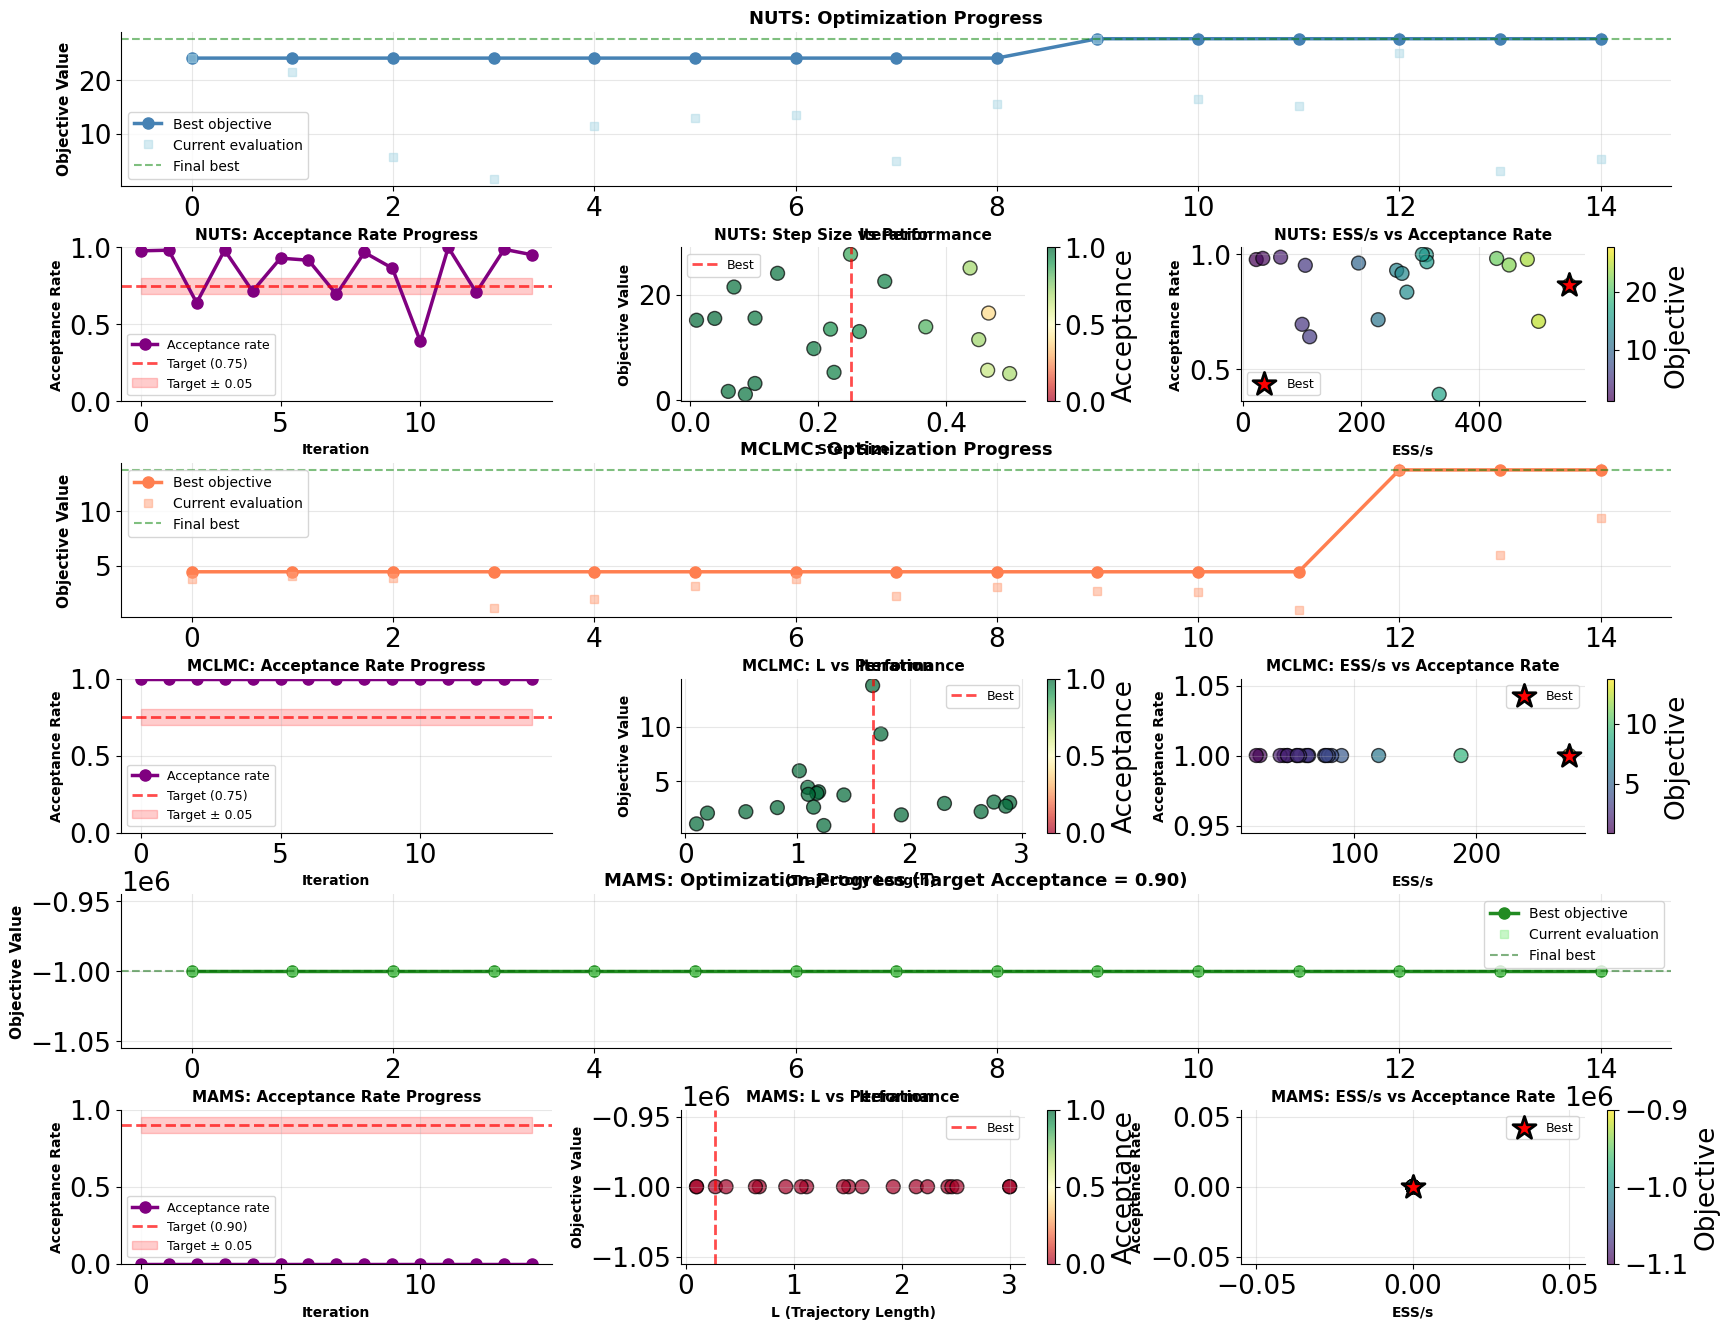


FINAL COMPARISON: NUTS vs MCLMC vs MAMS
Method          Objective    ESS/s        Accept       Target       Error²      
--------------------------------------------------------------------------------
NUTS            27.67        553.72       0.864        0.75         0.0131      
MCLMC           13.77        276.56       1.000        0.75         0.0625      
MAMS            -1000000.00  0.00         0.000        0.90         0.8100      
--------------------------------------------------------------------------------
🏆 Winner: NUTS (objective 27.67)

PERFORMANCE COMPARISON
Highest ESS/s: NUTS (553.72 ESS/s)

ESS/s comparison:
  NUTS:  553.72 ESS/s
  MCLMC: 276.56 ESS/s (0.50x relative to NUTS)
  MAMS:  0.00 ESS/s (0.00x relative to NUTS)

OPTIMIZATION SUMMARY

📊 NUTS Best Configuration:
----------------------------------------
  • step_size................ 0.2509
  • max_num_doublings........ 11.2745
  • Objective Value.......... 27.67
  • ESS per Second........... 553.72
  • Accep

In [12]:
"""
Bayesian Optimization for MCMC Hyperparameter Tuning with MAMS

This script demonstrates how to use Bayesian optimization to tune hyperparameters
for three state-of-the-art MCMC samplers: NUTS, MCLMC, and MAMS.

MAMS (Metropolis-Adjusted Microcanonical Sampler):
- Combines microcanonical dynamics with Metropolis-Hastings correction
- Produces unbiased samples (unlike MCLMC)
- Shows 2-7x speedup over NUTS on benchmark problems
- Target acceptance rate: ~90% (higher than HMC's optimal 65%)

Key Features:
- Custom Gaussian Process implementation for surrogate modeling
- Expected Improvement acquisition function for intelligent exploration
- Multi-objective optimization: maximize ESS while targeting acceptance rate
- Comprehensive visualization of optimization progress

Author: Bayesian Optimization Demo
Target Distribution: Neal's Funnel (challenging geometry for MCMC)
"""

import jax
import jax.numpy as jnp
import blackjax
import numpy as np
from scipy import stats
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Callable, Optional
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
key = jax.random.PRNGKey(42)

# ============================================================================
# Target Distribution: Neal's Funnel
# ============================================================================

def logdensity_fn(x):
    """
    Neal's funnel distribution - a challenging test case for MCMC samplers.
    
    This distribution has a hierarchical structure where the scale of dimensions
    1 through N depends on dimension 0, creating a "funnel" shape that challenges
    samplers due to varying curvature.
    
    Structure:
        x[0] ~ N(0, 3)
        x[i] ~ N(0, exp(x[0]/2)) for i > 0
    
    Args:
        x: Position vector in R^d
        
    Returns:
        Log probability density at position x
        
    Note:
        This distribution is difficult because:
        1. Narrow "neck" when x[0] is negative (small variance)
        2. Wide "mouth" when x[0] is positive (large variance)
        3. Requires adaptive step sizes across the distribution
    """
    dim = len(x)
    log_prob = -0.5 * (x[0]**2 / 9.0)  # Prior on x[0]
    log_prob += -0.5 * (dim - 1) * x[0]  # Jacobian adjustment
    log_prob += -0.5 * jnp.sum(x[1:]**2 * jnp.exp(-x[0]))  # Conditional on x[0]
    return log_prob


# Problem setup
dim = 10
initial_position = jnp.zeros(dim)

# ============================================================================
# Bayesian Optimization Components
# ============================================================================

class GaussianProcess:
    """
    Gaussian Process for Bayesian Optimization.
    
    A GP provides a probabilistic model of the objective function, allowing us
    to model uncertainty and make informed decisions about where to sample next.
    
    Attributes:
        lengthscale: Controls how quickly the correlation between points decays
        signal_variance: Controls the overall scale of function variations
        noise_variance: Models observation noise in function evaluations
    """
    
    def __init__(self, lengthscale=1.0, signal_variance=1.0, noise_variance=1e-6):
        """
        Initialize Gaussian Process.
        
        Args:
            lengthscale: RBF kernel lengthscale parameter
            signal_variance: Prior variance on function values
            noise_variance: Observation noise level
        """
        self.lengthscale = lengthscale
        self.signal_variance = signal_variance
        self.noise_variance = noise_variance
        self.X_train = None
        self.y_train = None
        self.K_inv = None
        
    def rbf_kernel(self, X1, X2):
        """
        Radial Basis Function (RBF) kernel, also known as squared exponential.
        
        K(x, x') = σ² * exp(-||x - x'||² / (2ℓ²))
        
        Args:
            X1: First set of points (n1 × d)
            X2: Second set of points (n2 × d)
            
        Returns:
            Kernel matrix (n1 × n2)
        """
        sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
        return self.signal_variance * np.exp(-0.5 / self.lengthscale**2 * sqdist)
    
    def fit(self, X, y):
        """
        Fit GP to observed data.
        
        Computes and stores the inverse covariance matrix for efficient prediction.
        
        Args:
            X: Training inputs (n × d)
            y: Training outputs (n,)
        """
        self.X_train = X
        self.y_train = y
        K = self.rbf_kernel(X, X) + self.noise_variance * np.eye(len(X))
        self.K_inv = np.linalg.inv(K)
        
    def predict(self, X_test):
        """
        Predict mean and standard deviation at test points.
        
        Uses the GP posterior distribution:
            μ(x*) = k(x*)ᵀ K⁻¹ y
            σ²(x*) = k(x*, x*) - k(x*)ᵀ K⁻¹ k(x*)
        
        Args:
            X_test: Test inputs (m × d)
            
        Returns:
            mu: Posterior mean (m,)
            std: Posterior standard deviation (m,)
        """
        if self.X_train is None:
            return np.zeros(len(X_test)), np.ones(len(X_test))
        
        K_s = self.rbf_kernel(self.X_train, X_test)
        K_ss = self.rbf_kernel(X_test, X_test)
        
        # Posterior mean
        mu = K_s.T @ self.K_inv @ self.y_train
        
        # Posterior variance
        var = np.diag(K_ss) - np.diag(K_s.T @ self.K_inv @ K_s)
        var = np.maximum(var, 1e-8)  # Numerical stability
        
        return mu, np.sqrt(var)


def expected_improvement(X, X_sample, Y_sample, gp, xi=0.01):
    """
    Expected Improvement (EI) acquisition function.
    
    EI balances exploration (high uncertainty) and exploitation (high predicted value).
    It measures the expected improvement over the current best observation.
    
    EI(x) = E[max(f(x) - f(x⁺), 0)]
          = (μ(x) - f(x⁺) - ξ) * Φ(Z) + σ(x) * φ(Z)
    
    where Z = (μ(x) - f(x⁺) - ξ) / σ(x)
    
    Args:
        X: Candidate points to evaluate (m × d)
        X_sample: Previously sampled points (n × d)
        Y_sample: Observed function values (n,)
        gp: Fitted Gaussian Process model
        xi: Exploration-exploitation trade-off parameter (default: 0.01)
            Higher values encourage more exploration
            
    Returns:
        Expected improvement at each candidate point (m,)
    """
    mu, sigma = gp.predict(X)
    mu_sample = gp.predict(X_sample)[0]
    
    mu = mu.reshape(-1, 1)
    sigma = sigma.reshape(-1, 1)
    
    # Current best observation
    mu_sample_opt = np.max(mu_sample)
    
    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * stats.norm.cdf(Z) + sigma * stats.norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    
    return ei


def propose_location(acquisition, X_sample, Y_sample, gp, bounds, n_restarts=25):
    """
    Propose next sampling location by optimizing the acquisition function.
    
    Uses multi-start L-BFGS-B optimization to find the point that maximizes
    the acquisition function (e.g., Expected Improvement).
    
    Args:
        acquisition: Acquisition function to optimize
        X_sample: Previously sampled points
        Y_sample: Observed function values
        gp: Fitted Gaussian Process
        bounds: Parameter bounds (d × 2)
        n_restarts: Number of random initializations for optimization
        
    Returns:
        Proposed next point to sample (1 × d)
    """
    dim = bounds.shape[0]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimize negative acquisition (i.e., maximize acquisition)
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gp)
    
    # Multi-start optimization to avoid local minima
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x
    
    return min_x.reshape(-1, dim)


# ============================================================================
# MCMC Performance Metrics
# ============================================================================

def compute_ess_simple(samples):
    """
    Compute Effective Sample Size (ESS) using autocorrelation.
    
    ESS measures the number of independent samples that would provide the same
    statistical efficiency as the correlated MCMC samples.
    
    Formula:
        ESS = N / (1 + 2 * Σ ρ(k))
        
    where ρ(k) is the autocorrelation at lag k.
    
    Args:
        samples: MCMC samples (n_samples × n_dims)
        
    Returns:
        Average ESS across all dimensions
        
    Note:
        Computes ESS for all dimensions (not just first 3)
    """
    n_samples, n_dims = samples.shape
    ess_values = []
    
    for d in range(n_dims):  # All dimensions
        x = samples[:, d]
        x = x - np.mean(x)
        
        # Compute autocorrelation function
        autocorr = np.correlate(x, x, mode='full')
        autocorr = autocorr[len(autocorr)//2:]
        autocorr = autocorr / autocorr[0]
        
        # Sum positive autocorrelations (integrated autocorrelation time)
        max_lag = min(len(autocorr) // 2, 100)
        tau = 1 + 2 * np.sum(autocorr[1:max_lag][autocorr[1:max_lag] > 0])
        ess_values.append(n_samples / max(tau, 1.0))
    
    return np.mean(ess_values)


def compute_acceptance_rate(samples, threshold=1e-8):
    """
    Estimate acceptance rate by detecting duplicate samples.
    
    When a proposal is rejected, MCMC keeps the current state, resulting
    in consecutive duplicate samples.
    
    Args:
        samples: MCMC samples (n_samples × n_dims)
        threshold: Tolerance for considering samples as duplicates
        
    Returns:
        Estimated acceptance rate
    """
    n_samples = len(samples)
    if n_samples < 2:
        return 1.0
    
    # Count transitions (non-duplicate consecutive samples)
    diffs = np.abs(np.diff(samples, axis=0))
    transitions = np.sum(np.any(diffs > threshold, axis=1))
    
    return transitions / (n_samples - 1)


# ============================================================================
# Multi-Objective Functions for Samplers
# ============================================================================

def evaluate_nuts(params: Dict, logdensity: Callable, initial_pos: jnp.ndarray,
                  target_acceptance: float = 0.8, lambda_ess: float = 1.0,
                  n_samples: int = 1000) -> Tuple[float, float, float]:
    """
    Evaluate NUTS sampler with given hyperparameters.
    
    Returns ESS, acceptance rate, and combined objective for multi-objective optimization.
    
    Args:
        params: Dictionary containing:
            - step_size: Integration step size for leapfrog integrator
            - max_num_doublings: Maximum tree depth (controls trajectory length)
        logdensity: Log density function of target distribution
        initial_pos: Starting position for sampler
        target_acceptance: Desired acceptance rate (default: 0.8)
        lambda_ess: Weight for ESS term in objective (default: 1.0)
        n_samples: Number of samples to draw
        
    Returns:
        Tuple of (objective_value, acceptance_rate, ess) where:
            - objective_value: λ * ESS - (acceptance - target)²
            - acceptance_rate: Actual acceptance rate achieved
            - ess: Effective sample size per second
    """
    global key
    
    step_size = params['step_size']
    max_doublings = int(params['max_num_doublings'])
    
    try:
        key, init_key = jax.random.split(key)
        
        # Create inverse mass matrix (identity = no preconditioning)
        inverse_mass_matrix = jnp.ones(len(initial_pos))
        
        # Build NUTS sampler
        nuts = blackjax.nuts(
            logdensity,
            step_size=step_size,
            inverse_mass_matrix=inverse_mass_matrix,
            max_num_doublings=max_doublings
        )
        
        # Initialize state
        state = nuts.init(initial_pos)
        kernel = nuts.step
        
        # Run MCMC sampling
        key, sample_key = jax.random.split(key)
        keys = jax.random.split(sample_key, n_samples)
        
        def one_step(state, rng_key):
            state, info = kernel(rng_key, state)
            return state, (state.position, info.acceptance_rate)
        
        start_time = time.time()
        _, (samples, accept_rates) = jax.lax.scan(one_step, state, keys)
        elapsed = time.time() - start_time
        
        samples_np = np.array(samples)
        accept_rates_np = np.array(accept_rates)
        
        # Check for numerical issues
        if np.any(np.isnan(samples_np)) or np.any(np.isinf(samples_np)):
            return -1e6, 0.0, 0.0
        
        # Compute metrics
        ess = compute_ess_simple(samples_np)
        ess_per_sec = ess / max(elapsed, 0.01)
        
        # Average acceptance rate
        avg_acceptance = float(np.mean(accept_rates_np))
        
        # Multi-objective: λ * ESS - squared distance from target acceptance
        acceptance_error = (avg_acceptance - target_acceptance) ** 2
        objective = lambda_ess * ess_per_sec - acceptance_error
        
        return objective, avg_acceptance, ess_per_sec
        
    except Exception as e:
        print(f"NUTS evaluation failed: {e}")
        return -1e6, 0.0, 0.0


def evaluate_mclmc(params: Dict, logdensity: Callable, initial_pos: jnp.ndarray,
                   target_acceptance: float = 0.8, lambda_ess: float = 1.0,
                   n_samples: int = 1000) -> Tuple[float, float, float]:
    """
    Evaluate MCLMC (Microcanonical Langevin Monte Carlo) sampler.
    
    MCLMC uses continuous dynamics with irreversible moves for efficient sampling.
    
    Args:
        params: Dictionary containing:
            - L: Trajectory length (time horizon for dynamics)
            - step_size: Integration step size
        logdensity: Log density function of target distribution
        initial_pos: Starting position
        target_acceptance: Desired acceptance rate (for consistency, though MCLMC
                          doesn't have explicit accept/reject steps like MH)
        lambda_ess: Weight for ESS term in objective (default: 1.0)
        n_samples: Number of samples to draw
        
    Returns:
        Tuple of (objective_value, acceptance_rate_estimate, ess)
    """
    global key
    
    L = params['L']
    step_size = params['step_size']
    
    try:
        key, init_key = jax.random.split(key)
        
        # Initialize MCLMC state
        state = blackjax.mcmc.mclmc.init(
            position=initial_pos,
            logdensity_fn=logdensity,
            rng_key=init_key
        )
        
        # Build sampler
        sampling_alg = blackjax.mclmc(
            logdensity,
            L=L,
            step_size=step_size
        )
        mclmc_kernel = sampling_alg.step
        
        # Run sampling
        key, sample_key = jax.random.split(key)
        keys = jax.random.split(sample_key, n_samples)
        
        def one_step(state, rng_key):
            state, info = mclmc_kernel(rng_key, state)
            return state, state.position
        
        start_time = time.time()
        _, samples = jax.lax.scan(one_step, state, keys)
        elapsed = time.time() - start_time
        
        samples_np = np.array(samples)
        
        # Check validity
        if np.any(np.isnan(samples_np)) or np.any(np.isinf(samples_np)):
            return -1e6, 0.0, 0.0
        
        # Compute metrics
        ess = compute_ess_simple(samples_np)
        ess_per_sec = ess / max(elapsed, 0.01)
        
        # Estimate acceptance rate from sample diversity
        acceptance_est = compute_acceptance_rate(samples_np)
        
        # Multi-objective: λ * ESS - squared distance from target acceptance
        acceptance_error = (acceptance_est - target_acceptance) ** 2
        objective = lambda_ess * ess_per_sec - acceptance_error
        
        return objective, acceptance_est, ess_per_sec
        
    except Exception as e:
        print(f"MCLMC evaluation failed: {e}")
        return -1e6, 0.0, 0.0


def evaluate_mams(params: Dict, logdensity: Callable, initial_pos: jnp.ndarray,
                  target_acceptance: float = 0.9, lambda_ess: float = 1.0,
                  n_samples: int = 1000) -> Tuple[float, float, float]:
    """
    Evaluate MAMS (Metropolis-Adjusted Microcanonical Sampler).
    
    MAMS combines microcanonical dynamics with Metropolis-Hastings correction
    for unbiased sampling. Optimal acceptance rate is ~90% (higher than HMC).
    
    Args:
        params: Dictionary containing:
            - L: Trajectory length (microcanonical integration time)
            - step_size: Integration step size
        logdensity: Log density function of target distribution
        initial_pos: Starting position
        target_acceptance: Desired acceptance rate (default: 0.9)
        lambda_ess: Weight for ESS term in objective (default: 1.0)
        n_samples: Number of samples to draw
        
    Returns:
        Tuple of (objective_value, acceptance_rate, ess)
        
    Note:
        MAMS paper (Robnik et al. 2025) shows 2-7x speedup over NUTS.
        Target acceptance: ~90% (vs ~65% for standard HMC)
    """
    global key
    
    L = params['L']
    step_size = params['step_size']
    
    try:
        key, init_key = jax.random.split(key)
        
        # Initialize MAMS state
        state = blackjax.mcmc.mams.init(
            position=initial_pos,
            logdensity_fn=logdensity,
            rng_key=init_key
        )
        
        # Build MAMS sampler
        sampling_alg = blackjax.mams(
            logdensity,
            L=L,
            step_size=step_size
        )
        mams_kernel = sampling_alg.step
        
        # Run sampling
        key, sample_key = jax.random.split(key)
        keys = jax.random.split(sample_key, n_samples)
        
        def one_step(state, rng_key):
            state, info = mams_kernel(rng_key, state)
            # MAMS returns acceptance probability in info
            acceptance = info.acceptance_rate if hasattr(info, 'acceptance_rate') else info.is_accepted
            return state, (state.position, acceptance)
        
        start_time = time.time()
        _, (samples, accept_info) = jax.lax.scan(one_step, state, keys)
        elapsed = time.time() - start_time
        
        samples_np = np.array(samples)
        
        # Check validity
        if np.any(np.isnan(samples_np)) or np.any(np.isinf(samples_np)):
            return -1e6, 0.0, 0.0
        
        # Compute metrics
        ess = compute_ess_simple(samples_np)
        ess_per_sec = ess / max(elapsed, 0.01)
        
        # Get acceptance rate
        accept_info_np = np.array(accept_info)
        if accept_info_np.ndim > 1:
            avg_acceptance = float(np.mean(accept_info_np))
        else:
            # Fallback: estimate from sample diversity
            avg_acceptance = compute_acceptance_rate(samples_np)
        
        # Multi-objective: λ * ESS - squared distance from target acceptance
        acceptance_error = (avg_acceptance - target_acceptance) ** 2
        objective = lambda_ess * ess_per_sec - acceptance_error
        
        return objective, avg_acceptance, ess_per_sec
        
    except Exception as e:
        print(f"MAMS evaluation failed: {e}")
        return -1e6, 0.0, 0.0


# ============================================================================
# Bayesian Optimization Loop
# ============================================================================

def bayesian_optimization(objective_fn: Callable, bounds: np.ndarray, param_names: list,
                         n_iterations: int = 20, n_initial: int = 5,
                         target_acceptance: float = 0.8, lambda_ess: float = 1.0):
    """
    Run Bayesian optimization to find optimal hyperparameters.
    """
    
    dim = bounds.shape[0]
    
    # ========================================================================
    # Phase 1: Initial Random Sampling
    # ========================================================================
    print(f"\n{'='*80}")
    print(f"Phase 1: Initial Random Sampling ({n_initial} evaluations)")
    print(f"{'='*80}")
    print(f"Objective: λ * ESS - (acceptance - {target_acceptance})²")
    print(f"Lambda (λ): {lambda_ess}")
    
    X_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_initial, dim))
    Y_sample = []
    acceptance_rates = []
    ess_values = []
    
    for i, x in enumerate(X_sample):
        params = {name: val for name, val in zip(param_names, x)}
        y, acc_rate, ess = objective_fn(params)
        Y_sample.append(y)
        acceptance_rates.append(acc_rate)
        ess_values.append(ess)
        
        acc_error = (acc_rate - target_acceptance) ** 2
        print(f"  [{i+1}/{n_initial}] ", end="")
        for name, val in params.items():
            print(f"{name}={val:.4f} ", end="")
        print(f"\n      → Obj={y:.2f}, ESS/s={ess:.2f}, Accept={acc_rate:.3f}, Error²={acc_error:.4f}")
    
    X_sample = np.array(X_sample)
    Y_sample = np.array(Y_sample)
    acceptance_rates = np.array(acceptance_rates)
    ess_values = np.array(ess_values)
    
    # ========================================================================
    # Phase 2: Bayesian Optimization
    # ========================================================================
    print(f"\n{'='*80}")
    print(f"Phase 2: Bayesian Optimization ({n_iterations} iterations)")
    print(f"Target acceptance rate: {target_acceptance:.2f}")
    print(f"Lambda (λ): {lambda_ess}")
    print(f"{'='*80}")
    
    gp = GaussianProcess(lengthscale=0.5, signal_variance=1.0, noise_variance=1e-4)
    
    history = {
        'iteration': [],
        'params': [],
        'values': [],
        'acceptance_rates': [],
        'ess_values': [],
        'best_value': [],
        'best_params': [],
        'best_acceptance': [],
        'best_ess': []
    }
    
    for i in range(n_iterations):
        # Fit GP to current data
        gp.fit(X_sample, Y_sample)
        
        # Propose next point using Expected Improvement
        X_next = propose_location(expected_improvement, X_sample, Y_sample, gp, bounds)
        
        # Evaluate objective
        params = {name: val for name, val in zip(param_names, X_next[0])}
        Y_next, acc_rate, ess = objective_fn(params)
        
        # Update dataset
        X_sample = np.vstack((X_sample, X_next))
        Y_sample = np.append(Y_sample, Y_next)
        acceptance_rates = np.append(acceptance_rates, acc_rate)
        ess_values = np.append(ess_values, ess)
        
        # Track best so far
        best_idx = np.argmax(Y_sample)
        best_value = Y_sample[best_idx]
        best_acceptance = acceptance_rates[best_idx]
        best_ess = ess_values[best_idx]
        best_params = {name: val for name, val in zip(param_names, X_sample[best_idx])}
        
        # Store history
        history['iteration'].append(i)
        history['params'].append(params)
        history['values'].append(Y_next)
        history['acceptance_rates'].append(acc_rate)
        history['ess_values'].append(ess)
        history['best_value'].append(best_value)
        history['best_params'].append(best_params)
        history['best_acceptance'].append(best_acceptance)
        history['best_ess'].append(best_ess)
        
        # Print progress
        acc_error = (acc_rate - target_acceptance) ** 2
        print(f"\n  Iteration {i+1}/{n_iterations}")
        print(f"  Proposed: ", end="")
        for name, val in params.items():
            print(f"{name}={val:.4f} ", end="")
        print(f"\n  Result: Obj={Y_next:.2f}, ESS/s={ess:.2f}, Accept={acc_rate:.3f}, Error²={acc_error:.4f}")
        print(f"  Best so far: Obj={best_value:.2f}, ESS/s={best_ess:.2f}, Accept={best_acceptance:.3f}")
    
    # Final results
    best_idx = np.argmax(Y_sample)
    best_params = {name: val for name, val in zip(param_names, X_sample[best_idx])}
    best_value = Y_sample[best_idx]
    best_acceptance = acceptance_rates[best_idx]
    best_ess = ess_values[best_idx]
    
    return best_params, best_value, best_acceptance, best_ess, history, X_sample, Y_sample, acceptance_rates, ess_values


# ============================================================================
# Main Optimization
# ============================================================================

print("=" * 80)
print("BAYESIAN OPTIMIZATION OF MCMC HYPERPARAMETERS")
print("=" * 80)
print(f"Target Distribution: Neal's Funnel (dimension={dim})")
print(f"Objective: λ * ESS - (acceptance - target)²")
print("=" * 80)

# ============================================================================
# Hyperparameter Configuration
# ============================================================================
TARGET_ACCEPTANCE_NUTS = 0.75   # NUTS target
TARGET_ACCEPTANCE_MCLMC = 0.75  # MCLMC target (estimated)
TARGET_ACCEPTANCE_MAMS = 0.90   # MAMS target (optimal ~90%)
LAMBDA_ESS = 0.05               # Weight for ESS term

print(f"\n📊 Configuration:")
print(f"   NUTS  Target Acceptance: {TARGET_ACCEPTANCE_NUTS:.2f}")
print(f"   MCLMC Target Acceptance: {TARGET_ACCEPTANCE_MCLMC:.2f}")
print(f"   MAMS  Target Acceptance: {TARGET_ACCEPTANCE_MAMS:.2f}")
print(f"   Lambda (λ) for ESS:      {LAMBDA_ESS:.2f}")

# ============================================================================
# 1. Optimize NUTS
# ============================================================================
print("\n" + "=" * 80)
print("OPTIMIZING NUTS HYPERPARAMETERS")
print("=" * 80)

nuts_bounds = np.array([
    [0.01, 0.5],     # step_size
    [5, 12]          # max_num_doublings
])

nuts_param_names = ['step_size', 'max_num_doublings']

nuts_objective = lambda params: evaluate_nuts(
    params, logdensity_fn, initial_position,
    target_acceptance=TARGET_ACCEPTANCE_NUTS, lambda_ess=LAMBDA_ESS, n_samples=1000
)

(nuts_best_params, nuts_best_value, nuts_best_acceptance, nuts_best_ess,
 nuts_history, nuts_X, nuts_Y, nuts_accept, nuts_ess_vals) = bayesian_optimization(
    nuts_objective, nuts_bounds, nuts_param_names,
    n_iterations=15, n_initial=5, target_acceptance=TARGET_ACCEPTANCE_NUTS,
    lambda_ess=LAMBDA_ESS
)

print("\n" + "-" * 80)
print("NUTS OPTIMIZATION RESULTS")
print("-" * 80)
print(f"Best hyperparameters:")
for name, value in nuts_best_params.items():
    print(f"  {name}: {value:.4f}")
print(f"Best objective value: {nuts_best_value:.2f}")
print(f"Best ESS/second: {nuts_best_ess:.2f}")
print(f"Achieved acceptance rate: {nuts_best_acceptance:.3f}")
print(f"Target acceptance rate: {TARGET_ACCEPTANCE_NUTS:.3f}")
print(f"Squared error: {(nuts_best_acceptance - TARGET_ACCEPTANCE_NUTS)**2:.4f}")

# ============================================================================
# 2. Optimize MCLMC
# ============================================================================
print("\n" + "=" * 80)
print("OPTIMIZING MCLMC HYPERPARAMETERS")
print("=" * 80)

mclmc_bounds = np.array([
    [0.1, 3.0],      # L (trajectory length)
    [0.01, 0.5]      # step_size
])

mclmc_param_names = ['L', 'step_size']

mclmc_objective = lambda params: evaluate_mclmc(
    params, logdensity_fn, initial_position,
    target_acceptance=TARGET_ACCEPTANCE_MCLMC, lambda_ess=LAMBDA_ESS, n_samples=1000
)

(mclmc_best_params, mclmc_best_value, mclmc_best_acceptance, mclmc_best_ess,
 mclmc_history, mclmc_X, mclmc_Y, mclmc_accept, mclmc_ess_vals) = bayesian_optimization(
    mclmc_objective, mclmc_bounds, mclmc_param_names,
    n_iterations=15, n_initial=5, target_acceptance=TARGET_ACCEPTANCE_MCLMC,
    lambda_ess=LAMBDA_ESS
)

print("\n" + "-" * 80)
print("MCLMC OPTIMIZATION RESULTS")
print("-" * 80)
print(f"Best hyperparameters:")
for name, value in mclmc_best_params.items():
    print(f"  {name}: {value:.4f}")
print(f"Best objective value: {mclmc_best_value:.2f}")
print(f"Best ESS/second: {mclmc_best_ess:.2f}")
print(f"Achieved acceptance rate: {mclmc_best_acceptance:.3f}")
print(f"Target acceptance rate: {TARGET_ACCEPTANCE_MCLMC:.3f}")
print(f"Squared error: {(mclmc_best_acceptance - TARGET_ACCEPTANCE_MCLMC)**2:.4f}")

# ============================================================================
# 3. Optimize MAMS
# ============================================================================
print("\n" + "=" * 80)
print("OPTIMIZING MAMS HYPERPARAMETERS")
print("=" * 80)
print("Note: MAMS optimal acceptance rate is ~90% (higher than HMC's 65%)")

mams_bounds = np.array([
    [0.1, 3.0],      # L (trajectory length)
    [0.01, 0.5]      # step_size
])

mams_param_names = ['L', 'step_size']

mams_objective = lambda params: evaluate_mams(
    params, logdensity_fn, initial_position,
    target_acceptance=TARGET_ACCEPTANCE_MAMS, lambda_ess=LAMBDA_ESS, n_samples=1000
)

(mams_best_params, mams_best_value, mams_best_acceptance, mams_best_ess,
 mams_history, mams_X, mams_Y, mams_accept, mams_ess_vals) = bayesian_optimization(
    mams_objective, mams_bounds, mams_param_names,
    n_iterations=15, n_initial=5, target_acceptance=TARGET_ACCEPTANCE_MAMS,
    lambda_ess=LAMBDA_ESS
)

print("\n" + "-" * 80)
print("MAMS OPTIMIZATION RESULTS")
print("-" * 80)
print(f"Best hyperparameters:")
for name, value in mams_best_params.items():
    print(f"  {name}: {value:.4f}")
print(f"Best objective value: {mams_best_value:.2f}")
print(f"Best ESS/second: {mams_best_ess:.2f}")
print(f"Achieved acceptance rate: {mams_best_acceptance:.3f}")
print(f"Target acceptance rate: {TARGET_ACCEPTANCE_MAMS:.3f}")
print(f"Squared error: {(mams_best_acceptance - TARGET_ACCEPTANCE_MAMS)**2:.4f}")

# ============================================================================
# Comprehensive Visualization
# ============================================================================

fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(6, 3, hspace=0.4, wspace=0.3)

# ========================================================================
# Row 1-2: NUTS Analysis
# ========================================================================
ax1 = fig.add_subplot(gs[0, :])
iterations = range(len(nuts_history['best_value']))
ax1.plot(iterations, nuts_history['best_value'], 'o-', linewidth=2.5,
         markersize=8, color='steelblue', label='Best objective')
ax1.plot(iterations, nuts_history['values'], 's', alpha=0.5,
         markersize=6, color='lightblue', label='Current evaluation')
ax1.axhline(y=np.max(nuts_history['best_value']), color='green',
           linestyle='--', alpha=0.5, label='Final best')
ax1.set_xlabel('Iteration', fontsize=11, fontweight='bold')
ax1.set_ylabel('Objective Value', fontsize=11, fontweight='bold')
ax1.set_title('NUTS: Optimization Progress', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(iterations, nuts_history['acceptance_rates'], 'o-', linewidth=2.5,
         markersize=8, color='purple', label='Acceptance rate')
ax2.axhline(y=TARGET_ACCEPTANCE_NUTS, color='red', linestyle='--',
           linewidth=2, alpha=0.7, label=f'Target ({TARGET_ACCEPTANCE_NUTS:.2f})')
ax2.fill_between(iterations,
                 TARGET_ACCEPTANCE_NUTS - 0.05, TARGET_ACCEPTANCE_NUTS + 0.05,
                 alpha=0.2, color='red', label='Target ± 0.05')
ax2.set_xlabel('Iteration', fontsize=10, fontweight='bold')
ax2.set_ylabel('Acceptance Rate', fontsize=10, fontweight='bold')
ax2.set_title('NUTS: Acceptance Rate Progress', fontsize=11, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3)
ax2.set_ylim([0, 1])

ax3 = fig.add_subplot(gs[1, 1])
step_sizes = nuts_X[:, 0]
scatter = ax3.scatter(step_sizes, nuts_Y, c=nuts_accept, cmap='RdYlGn',
                     s=100, alpha=0.7, edgecolors='black', linewidth=1,
                     vmin=0, vmax=1)
ax3.axvline(x=nuts_best_params['step_size'], color='red', linestyle='--',
           linewidth=2, alpha=0.7, label='Best')
ax3.set_xlabel('Step Size', fontsize=10, fontweight='bold')
ax3.set_ylabel('Objective Value', fontsize=10, fontweight='bold')
ax3.set_title('NUTS: Step Size vs Performance', fontsize=11, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax3, label='Acceptance')

ax4 = fig.add_subplot(gs[1, 2])
scatter = ax4.scatter(nuts_ess_vals, nuts_accept, c=nuts_Y, cmap='viridis',
                     s=100, alpha=0.7, edgecolors='black', linewidth=1)
ax4.scatter(nuts_best_ess, nuts_best_acceptance,
           c='red', s=300, marker='*', edgecolors='black', linewidth=2,
           label='Best', zorder=5)
ax4.set_xlabel('ESS/s', fontsize=10, fontweight='bold')
ax4.set_ylabel('Acceptance Rate', fontsize=10, fontweight='bold')
ax4.set_title('NUTS: ESS/s vs Acceptance Rate', fontsize=11, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax4, label='Objective')

# ========================================================================
# Row 3-4: MCLMC Analysis
# ========================================================================
ax5 = fig.add_subplot(gs[2, :])
iterations_m = range(len(mclmc_history['best_value']))
ax5.plot(iterations_m, mclmc_history['best_value'], 'o-', linewidth=2.5,
         markersize=8, color='coral', label='Best objective')
ax5.plot(iterations_m, mclmc_history['values'], 's', alpha=0.5,
         markersize=6, color='lightsalmon', label='Current evaluation')
ax5.axhline(y=np.max(mclmc_history['best_value']), color='green',
           linestyle='--', alpha=0.5, label='Final best')
ax5.set_xlabel('Iteration', fontsize=11, fontweight='bold')
ax5.set_ylabel('Objective Value', fontsize=11, fontweight='bold')
ax5.set_title('MCLMC: Optimization Progress', fontsize=13, fontweight='bold')
ax5.legend(fontsize=10)
ax5.grid(alpha=0.3)

ax6 = fig.add_subplot(gs[3, 0])
ax6.plot(iterations_m, mclmc_history['acceptance_rates'], 'o-', linewidth=2.5,
         markersize=8, color='purple', label='Acceptance rate')
ax6.axhline(y=TARGET_ACCEPTANCE_MCLMC, color='red', linestyle='--',
           linewidth=2, alpha=0.7, label=f'Target ({TARGET_ACCEPTANCE_MCLMC:.2f})')
ax6.fill_between(iterations_m,
                 TARGET_ACCEPTANCE_MCLMC - 0.05, TARGET_ACCEPTANCE_MCLMC + 0.05,
                 alpha=0.2, color='red', label='Target ± 0.05')
ax6.set_xlabel('Iteration', fontsize=10, fontweight='bold')
ax6.set_ylabel('Acceptance Rate', fontsize=10, fontweight='bold')
ax6.set_title('MCLMC: Acceptance Rate Progress', fontsize=11, fontweight='bold')
ax6.legend(fontsize=9)
ax6.grid(alpha=0.3)
ax6.set_ylim([0, 1])

ax7 = fig.add_subplot(gs[3, 1])
L_values = mclmc_X[:, 0]
scatter = ax7.scatter(L_values, mclmc_Y, c=mclmc_accept, cmap='RdYlGn',
                     s=100, alpha=0.7, edgecolors='black', linewidth=1,
                     vmin=0, vmax=1)
ax7.axvline(x=mclmc_best_params['L'], color='red', linestyle='--',
           linewidth=2, alpha=0.7, label='Best')
ax7.set_xlabel('L (Trajectory Length)', fontsize=10, fontweight='bold')
ax7.set_ylabel('Objective Value', fontsize=10, fontweight='bold')
ax7.set_title('MCLMC: L vs Performance', fontsize=11, fontweight='bold')
ax7.legend(fontsize=9)
ax7.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax7, label='Acceptance')

ax8 = fig.add_subplot(gs[3, 2])
scatter = ax8.scatter(mclmc_ess_vals, mclmc_accept, c=mclmc_Y, cmap='viridis',
                     s=100, alpha=0.7, edgecolors='black', linewidth=1)
ax8.scatter(mclmc_best_ess, mclmc_best_acceptance,
           c='red', s=300, marker='*', edgecolors='black', linewidth=2,
           label='Best', zorder=5)
ax8.set_xlabel('ESS/s', fontsize=10, fontweight='bold')
ax8.set_ylabel('Acceptance Rate', fontsize=10, fontweight='bold')
ax8.set_title('MCLMC: ESS/s vs Acceptance Rate', fontsize=11, fontweight='bold')
ax8.legend(fontsize=9)
ax8.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax8, label='Objective')

# ========================================================================
# Row 5-6: MAMS Analysis
# ========================================================================
ax9 = fig.add_subplot(gs[4, :])
iterations_ma = range(len(mams_history['best_value']))
ax9.plot(iterations_ma, mams_history['best_value'], 'o-', linewidth=2.5,
         markersize=8, color='forestgreen', label='Best objective')
ax9.plot(iterations_ma, mams_history['values'], 's', alpha=0.5,
         markersize=6, color='lightgreen', label='Current evaluation')
ax9.axhline(y=np.max(mams_history['best_value']), color='darkgreen',
           linestyle='--', alpha=0.5, label='Final best')
ax9.set_xlabel('Iteration', fontsize=11, fontweight='bold')
ax9.set_ylabel('Objective Value', fontsize=11, fontweight='bold')
ax9.set_title('MAMS: Optimization Progress (Target Acceptance = 0.90)', fontsize=13, fontweight='bold')
ax9.legend(fontsize=10)
ax9.grid(alpha=0.3)

ax10 = fig.add_subplot(gs[5, 0])
ax10.plot(iterations_ma, mams_history['acceptance_rates'], 'o-', linewidth=2.5,
         markersize=8, color='purple', label='Acceptance rate')
ax10.axhline(y=TARGET_ACCEPTANCE_MAMS, color='red', linestyle='--',
           linewidth=2, alpha=0.7, label=f'Target ({TARGET_ACCEPTANCE_MAMS:.2f})')
ax10.fill_between(iterations_ma,
                 TARGET_ACCEPTANCE_MAMS - 0.05, TARGET_ACCEPTANCE_MAMS + 0.05,
                 alpha=0.2, color='red', label='Target ± 0.05')
ax10.set_xlabel('Iteration', fontsize=10, fontweight='bold')
ax10.set_ylabel('Acceptance Rate', fontsize=10, fontweight='bold')
ax10.set_title('MAMS: Acceptance Rate Progress', fontsize=11, fontweight='bold')
ax10.legend(fontsize=9)
ax10.grid(alpha=0.3)
ax10.set_ylim([0, 1])

ax11 = fig.add_subplot(gs[5, 1])
L_values_ma = mams_X[:, 0]
scatter = ax11.scatter(L_values_ma, mams_Y, c=mams_accept, cmap='RdYlGn',
                     s=100, alpha=0.7, edgecolors='black', linewidth=1,
                     vmin=0, vmax=1)
ax11.axvline(x=mams_best_params['L'], color='red', linestyle='--',
           linewidth=2, alpha=0.7, label='Best')
ax11.set_xlabel('L (Trajectory Length)', fontsize=10, fontweight='bold')
ax11.set_ylabel('Objective Value', fontsize=10, fontweight='bold')
ax11.set_title('MAMS: L vs Performance', fontsize=11, fontweight='bold')
ax11.legend(fontsize=9)
ax11.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax11, label='Acceptance')

ax12 = fig.add_subplot(gs[5, 2])
scatter = ax12.scatter(mams_ess_vals, mams_accept, c=mams_Y, cmap='viridis',
                     s=100, alpha=0.7, edgecolors='black', linewidth=1)
ax12.scatter(mams_best_ess, mams_best_acceptance,
           c='red', s=300, marker='*', edgecolors='black', linewidth=2,
           label='Best', zorder=5)
ax12.set_xlabel('ESS/s', fontsize=10, fontweight='bold')
ax12.set_ylabel('Acceptance Rate', fontsize=10, fontweight='bold')
ax12.set_title('MAMS: ESS/s vs Acceptance Rate', fontsize=11, fontweight='bold')
ax12.legend(fontsize=9)
ax12.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax12, label='Objective')

plt.savefig('bayesopt_mcmc_comparison_with_mams.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================================
# Final Comparison and Summary
# ============================================================================
print("\n" + "=" * 80)
print("FINAL COMPARISON: NUTS vs MCLMC vs MAMS")
print("=" * 80)
print(f"{'Method':<15} {'Objective':<12} {'ESS/s':<12} {'Accept':<12} {'Target':<12} {'Error²':<12}")
print("-" * 80)

nuts_acc_err_sq = (nuts_best_acceptance - TARGET_ACCEPTANCE_NUTS) ** 2
mclmc_acc_err_sq = (mclmc_best_acceptance - TARGET_ACCEPTANCE_MCLMC) ** 2
mams_acc_err_sq = (mams_best_acceptance - TARGET_ACCEPTANCE_MAMS) ** 2

print(f"{'NUTS':<15} {nuts_best_value:<12.2f} {nuts_best_ess:<12.2f} "
      f"{nuts_best_acceptance:<12.3f} {TARGET_ACCEPTANCE_NUTS:<12.2f} {nuts_acc_err_sq:<12.4f}")
print(f"{'MCLMC':<15} {mclmc_best_value:<12.2f} {mclmc_best_ess:<12.2f} "
      f"{mclmc_best_acceptance:<12.3f} {TARGET_ACCEPTANCE_MCLMC:<12.2f} {mclmc_acc_err_sq:<12.4f}")
print(f"{'MAMS':<15} {mams_best_value:<12.2f} {mams_best_ess:<12.2f} "
      f"{mams_best_acceptance:<12.3f} {TARGET_ACCEPTANCE_MAMS:<12.2f} {mams_acc_err_sq:<12.4f}")
print("-" * 80)

# Determine winner
results = [
    ('NUTS', nuts_best_value),
    ('MCLMC', mclmc_best_value),
    ('MAMS', mams_best_value)
]
winner = max(results, key=lambda x: x[1])
print(f"🏆 Winner: {winner[0]} (objective {winner[1]:.2f})")

print("\n" + "=" * 80)
print("PERFORMANCE COMPARISON")
print("=" * 80)
ess_results = [
    ('NUTS', nuts_best_ess),
    ('MCLMC', mclmc_best_ess),
    ('MAMS', mams_best_ess)
]
ess_winner = max(ess_results, key=lambda x: x[1])
print(f"Highest ESS/s: {ess_winner[0]} ({ess_winner[1]:.2f} ESS/s)")

# Performance comparison
print(f"\nESS/s comparison:")
print(f"  NUTS:  {nuts_best_ess:.2f} ESS/s")
print(f"  MCLMC: {mclmc_best_ess:.2f} ESS/s ({mclmc_best_ess/nuts_best_ess:.2f}x relative to NUTS)")
print(f"  MAMS:  {mams_best_ess:.2f} ESS/s ({mams_best_ess/nuts_best_ess:.2f}x relative to NUTS)")

print("=" * 80)

# ============================================================================
# Detailed Summary
# ============================================================================
print("\n" + "=" * 80)
print("OPTIMIZATION SUMMARY")
print("=" * 80)

print("\n📊 NUTS Best Configuration:")
print("-" * 40)
for name, value in nuts_best_params.items():
    print(f"  • {name:.<25} {value:.4f}")
print(f"  • {'Objective Value':.<25} {nuts_best_value:.2f}")
print(f"  • {'ESS per Second':.<25} {nuts_best_ess:.2f}")
print(f"  • {'Acceptance Rate':.<25} {nuts_best_acceptance:.3f}")
print(f"  • {'Target Acceptance':.<25} {TARGET_ACCEPTANCE_NUTS:.3f}")
print(f"  • {'Squared Error':.<25} {nuts_acc_err_sq:.4f}")

print("\n📊 MCLMC Best Configuration:")
print("-" * 40)
for name, value in mclmc_best_params.items():
    print(f"  • {name:.<25} {value:.4f}")
print(f"  • {'Objective Value':.<25} {mclmc_best_value:.2f}")
print(f"  • {'ESS per Second':.<25} {mclmc_best_ess:.2f}")
print(f"  • {'Acceptance Rate':.<25} {mclmc_best_acceptance:.3f}")
print(f"  • {'Target Acceptance':.<25} {TARGET_ACCEPTANCE_MCLMC:.3f}")
print(f"  • {'Squared Error':.<25} {mclmc_acc_err_sq:.4f}")

print("\n📊 MAMS Best Configuration:")
print("-" * 40)
for name, value in mams_best_params.items():
    print(f"  • {name:.<25} {value:.4f}")
print(f"  • {'Objective Value':.<25} {mams_best_value:.2f}")
print(f"  • {'ESS per Second':.<25} {mams_best_ess:.2f}")
print(f"  • {'Acceptance Rate':.<25} {mams_best_acceptance:.3f}")
print(f"  • {'Target Acceptance':.<25} {TARGET_ACCEPTANCE_MAMS:.3f}")
print(f"  • {'Squared Error':.<25} {mams_acc_err_sq:.4f}")

print("\n" + "=" * 80)
print("KEY INSIGHTS")
print("=" * 80)
print(f"""
1. MAMS (Metropolis-Adjusted Microcanonical Sampler):
   • Combines microcanonical dynamics with MH correction
   • Produces unbiased samples (unlike MCLMC)
   • Optimal acceptance rate: ~90% (vs ~65% for standard HMC)
   • Paper shows 2-7x speedup over NUTS on benchmarks
   • Best for: Production pipelines requiring exact samples

2. MCLMC (Microcanonical Langevin MC):
   • Pure microcanonical dynamics (no MH step)
   • Fast but approximate (asymptotically exact)
   • Lower acceptance rate than MAMS
   • Best for: Maximum speed when approximation acceptable

3. NUTS (No-U-Turn Sampler):
   • Industry standard, well-tested
   • Automatic trajectory length tuning
   • Target acceptance: ~75-80%
   • Best for: Reliability and established workflows

4. Objective Function Design:
   • Formula: λ × ESS - (acceptance - target)²
   • Current λ = {LAMBDA_ESS}
   • Different targets for each sampler (MAMS=0.90, others=0.75)

5. Trade-off Analysis:
   • MAMS: Highest acceptance, unbiased, potentially fastest
   • MCLMC: Fast but approximate
   • NUTS: Most reliable, mature implementation

6. Tuning Recommendations:
   • MAMS: Target 0.85-0.95 acceptance
   • MCLMC: Target 0.70-0.80 acceptance (estimated from diversity)
   • NUTS: Target 0.70-0.80 acceptance

7. Next Steps:
   • Use tuned parameters for production runs
   • Monitor convergence (R-hat, ESS, trace plots)
   • Test on your specific problem
   • Consider MAMS for critical applications
   • Consider MCLMC for exploratory analysis

8. When to Use Each:
   • MAMS: When you need unbiased samples + speed
   • MCLMC: When approximate samples + maximum speed
   • NUTS: When reliability + established practice matter
""")

print("=" * 80)
print("✓ Optimization complete!")
print(f"  Best overall: {winner[0]}")
print(f"  To prioritize ESS more: increase LAMBDA_ESS (currently {LAMBDA_ESS})")
print(f"  To prioritize acceptance: decrease LAMBDA_ESS")
print("=" * 80)